In [35]:
from collections import defaultdict
from itertools import count

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import h5py
from tenpy.tools import hdf5_io

import os

In [4]:
from spt_classification import *

# Definitions & global variables

In [7]:
np_X = np.array([[0,1],[1,0]])

In [8]:
np_I = np.array([[1,0],[0,1]])

# Update code

Don't optimize just yet, just get it working.

This won't update one by one but by batches... but that's ok for now.

In [5]:
from functools import reduce

In [6]:
from itertools import count

In [7]:
l = list(range(10))

In [8]:
l[:0:-1]

[9, 8, 7, 6, 5, 4, 3, 2, 1]

In [33]:
def one_site_solve_sweep_right(psi, left_environment, symmetry_block_tm,
    left_unitaries, right_unitaries, starting_index, len_symmetry_block):

    right_starting_index = (
        starting_index
        + len(left_unitaries)
        + len_symmetry_block
    )

    ending_index = right_starting_index + len(right_unitaries) - 1

    right_environment = npc.eye_like(
        psi.get_B(ending_index),
        axis=-1,
        labels = ['vL', 'vL*'],
    )

    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )

    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )

    current_left_environment = reduce(
        multiply_transfer_matrices,
        left_transfer_matrices + [symmetry_block_tm,],
        left_environment
    )

    right_environments = list(accumulate(
        right_transfer_matrices[:0:-1],
        multiply_transfer_matrices_from_right,
        initial=right_environment
    ))

    loop_iter = zip(
        count(),
        count(right_starting_index),
        right_environments[::-1]
    )

    for i, psi_i, r_env in loop_iter:
        gradient = get_matrix_gradient(
            psi, psi_i, current_left_environment, r_env
        )
        new_u = unitarize_matrix(np.conj(gradient))

        right_unitaries[i] = new_u

        new_tm = get_transfer_matrix_from_unitary(psi, new_u, psi_i)
        current_left_environment = multiply_transfer_matrices(
            current_left_environment, new_tm
        )

In [101]:
def pad_unitaries(data):
    left_unitaries, right_unitaries = data[3:5]
    out = (
        *data[:3],
        ([np_I,] + left_unitaries),
        (right_unitaries + [np_I,]),
        (data[5] - 1),
        *data[6:]
    )

    return out

In [19]:
def one_site_solve_sweep_left(psi, left_environment, symmetry_block_tm,
    left_unitaries, right_unitaries, starting_index, len_symmetry_block):
    
    right_starting_index = (
        starting_index
        + len(left_unitaries)
        + len_symmetry_block
    )

    ending_index = right_starting_index + len(right_unitaries) - 1

    right_environment = npc.eye_like(
        psi.get_B(ending_index),
        axis=-1,
        labels = ['vL', 'vL*'],
    )

    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )

    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )

    current_right_environment = reduce(
        multiply_transfer_matrices_from_right,
        right_transfer_matrices[::-1] + [symmetry_block_tm,],
        right_environment
    )

    left_environments = list(accumulate(
        left_transfer_matrices[:-1],
        multiply_transfer_matrices,
        initial=left_environment
    ))

    loop_iter = zip(
        count(-1, -1),
        count(starting_index + len(left_unitaries) -1, -1),
        left_environments[::-1]
    )
        
    for i, psi_i, l_env in loop_iter:
        gradient = get_matrix_gradient(
            psi, psi_i, l_env, current_right_environment
        )
        new_u = unitarize_matrix(np.conj(gradient))
        left_unitaries[i] = new_u

        new_tm = get_transfer_matrix_from_unitary(psi, new_u, psi_i)
        current_right_environment = multiply_transfer_matrices(
            new_tm, current_right_environment
        )

In [20]:
def grad_descent_step_new(psi, left_environment, symmetry_block_tm, left_unitaries,
                      right_unitaries, starting_index, len_symmetry_block,
                      losses):

    one_site_solve_sweep_right(
        psi,
        left_environment,
        symmetry_block_tm,
        left_unitaries,
        right_unitaries,
        starting_index,
        len_symmetry_block
    )
    
    one_site_solve_sweep_left(
        psi,
        left_environment,
        symmetry_block_tm,
        left_unitaries,
        right_unitaries,
        starting_index,
        len_symmetry_block
    )

    left_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, left_unitaries, starting_index
    )

    right_transfer_matrices = get_transfer_matrices_from_unitary_list(
        psi, right_unitaries, starting_index + len(left_unitaries) + len_symmetry_block
    )

    expectation = matrix_element(
        left_environment,
        left_transfer_matrices,
        symmetry_block_tm,
        right_transfer_matrices
    )

    losses.append(1 - np.abs(expectation))

# Load data

In [21]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [22]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [23]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [24]:
psi_dict = dict()

In [25]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

In [26]:
list(psi_dict)

[0.0,
 0.1,
 0.2,
 0.3,
 0.4,
 0.5,
 0.6,
 0.7,
 0.8,
 0.9,
 1.0,
 1.1,
 1.2,
 1.3,
 1.4,
 1.5,
 1.6,
 1.7,
 1.8,
 1.9,
 2.0]

# Symmetry actions

In [27]:
symmetry_actions = {
    "X1": [np_X, np_I]*50,
    "X2": [np_I, np_X]*50,
    "X12": [np_I, np_X]*50
}

# Testing

In [28]:
results_dict = defaultdict(lambda: defaultdict(dict))

## B=0

In [29]:
b = 0

In [30]:
n=2

In [31]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [36]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

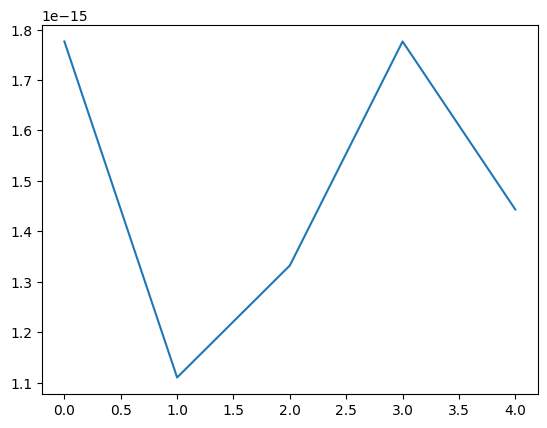

In [37]:
plt.plot(results_dict[b]["X1"][n][-1])

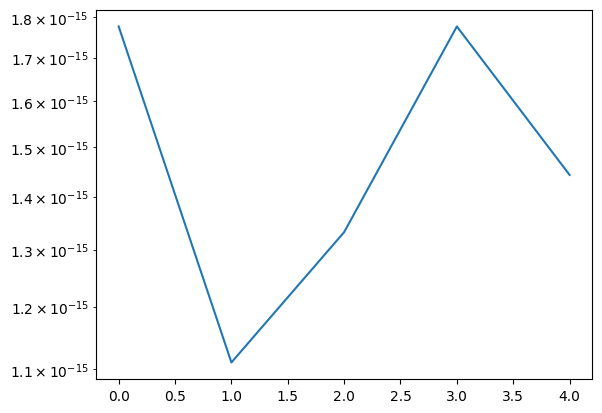

In [38]:
plt.semilogy(results_dict[0]["X1"][n][-1])

In [39]:
results_dict[0]["X1"][n][-1][-1]

1.4432899320127035e-15

In [40]:
for _ in range(5):
    grad_descent_step_new(*results_dict[0]["X2"][n])

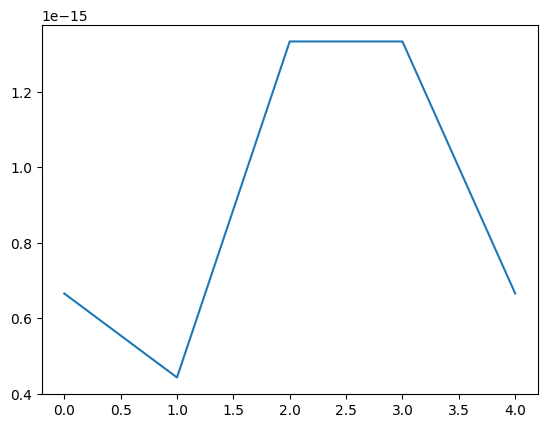

In [41]:
plt.plot(results_dict[0]["X2"][n][-1])

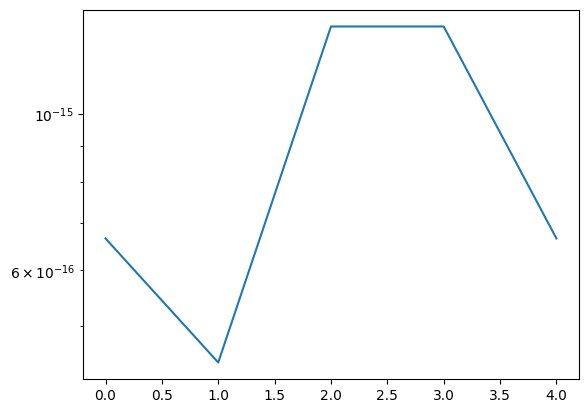

In [42]:
plt.semilogy(results_dict[0]["X2"][n][-1])

In [43]:
results_dict[0]["X2"][n][-1][-1]

6.661338147750939e-16

In [44]:
for _ in range(5):
    grad_descent_step_new(*results_dict[0]["X12"][n])

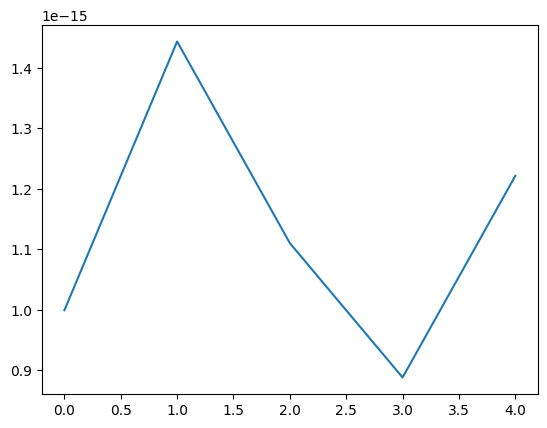

In [45]:
plt.plot(results_dict[0]["X12"][n][-1])

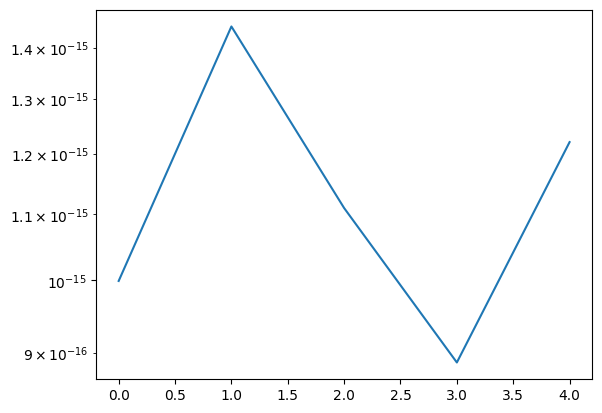

In [46]:
plt.semilogy(results_dict[0]["X12"][n][-1])

In [47]:
results_dict[0]["X12"][n][-1][-1]

1.2212453270876722e-15

## B=0.1

In [48]:
b = 0.1

In [49]:
n=2

In [50]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [51]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

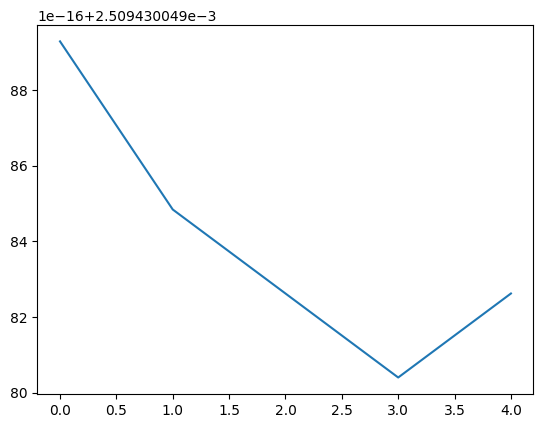

In [52]:
plt.plot(results_dict[b]["X1"][n][-1])

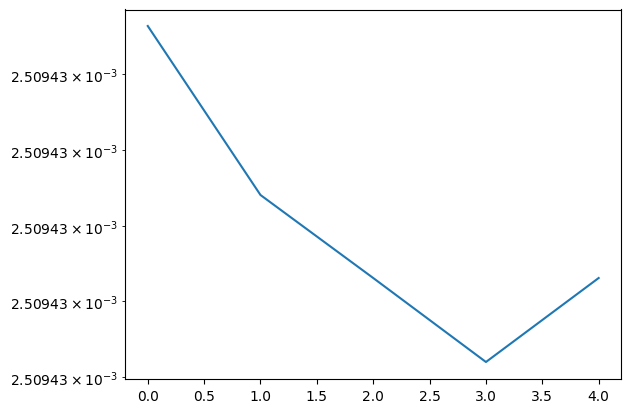

In [53]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [54]:
results_dict[b]["X1"][n][-1][-1]

0.0025094300488882615

In [55]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

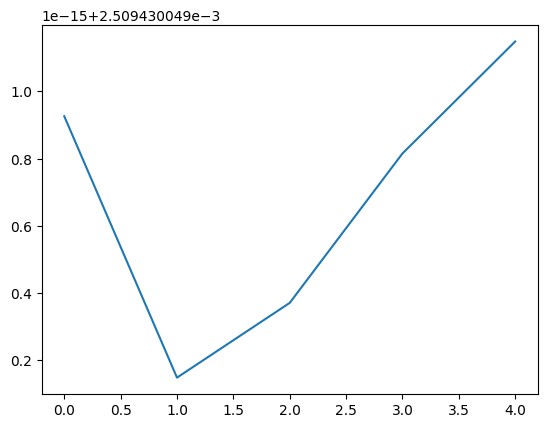

In [56]:
plt.plot(results_dict[b]["X2"][n][-1])

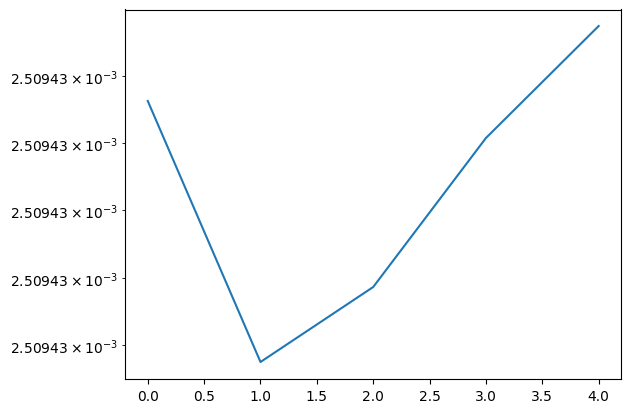

In [57]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [58]:
results_dict[b]["X2"][n][-1][-1]

0.002509430048891148

In [59]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

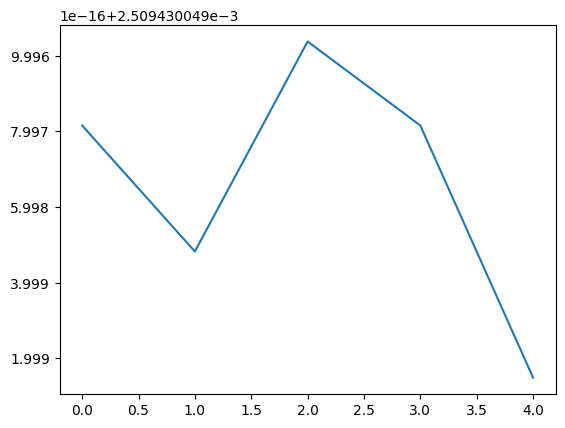

In [60]:
plt.plot(results_dict[b]["X12"][n][-1])

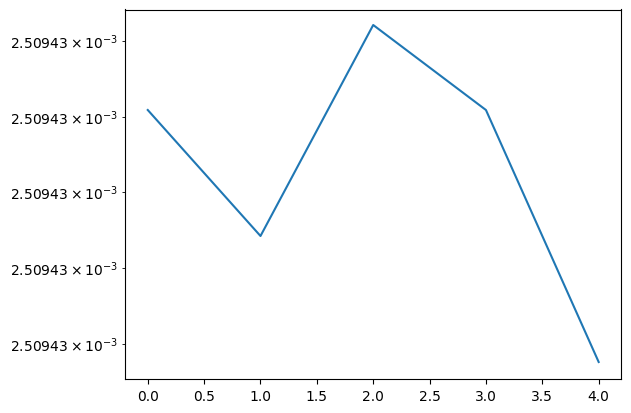

In [61]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [62]:
results_dict[b]["X12"][n][-1][-1]

0.002509430048890149

In [63]:
n=3

In [64]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [65]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

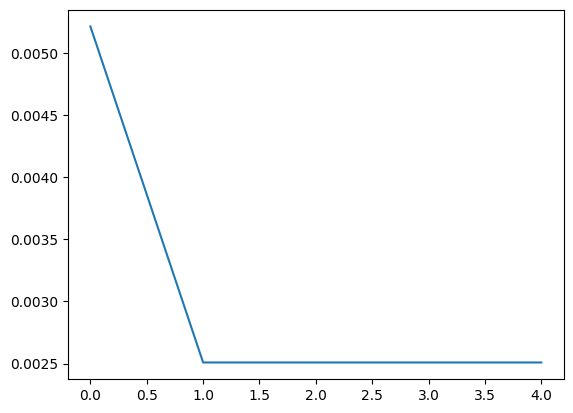

In [66]:
plt.plot(results_dict[b]["X1"][n][-1])

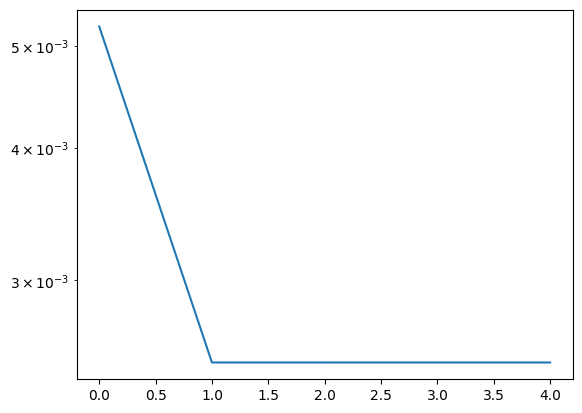

In [67]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [68]:
results_dict[b]["X1"][n][-1][-1]

0.0025094300488888166

In [69]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

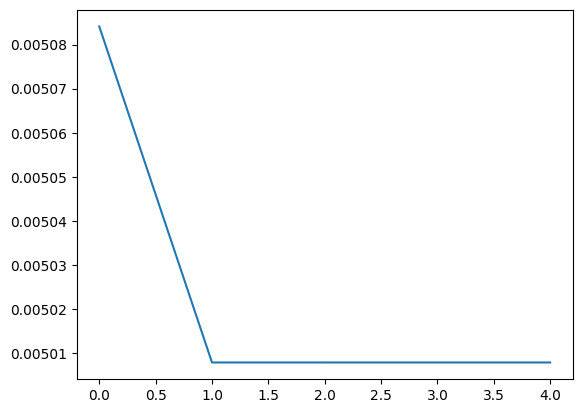

In [70]:
plt.plot(results_dict[b]["X2"][n][-1])

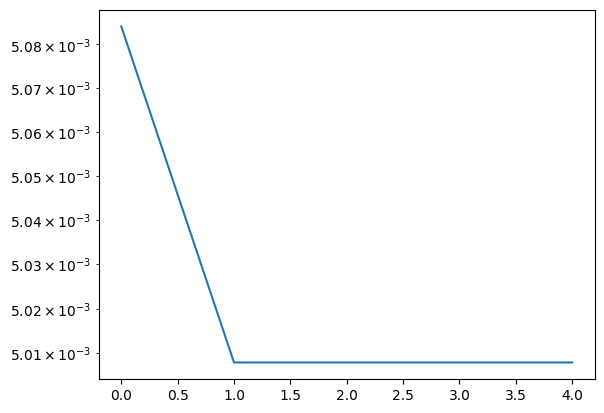

In [71]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [72]:
results_dict[b]["X2"][n][-1][-1]

0.0050078517959413205

In [73]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

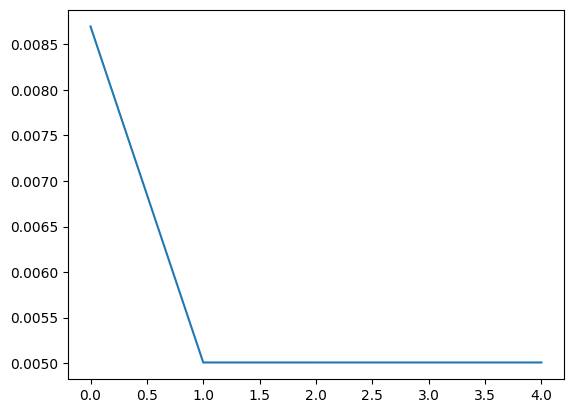

In [74]:
plt.plot(results_dict[b]["X12"][n][-1])

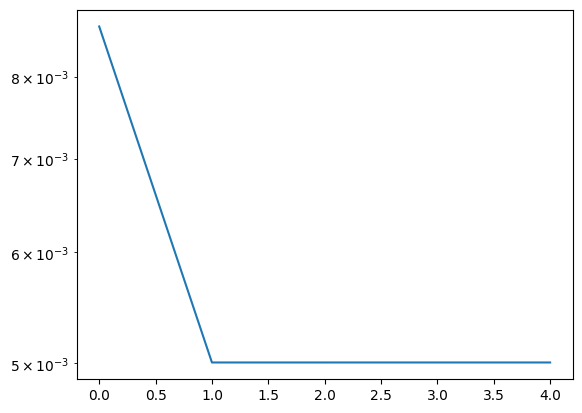

In [75]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [76]:
results_dict[b]["X12"][n][-1][-1]

0.0050078517959416535

### Pad

Solution with more unitary sites doing worse, so pad instead.

In [107]:
n=2

In [102]:
padded_data_01_X1_2 = pad_unitaries(results_dict[b]["X1"][n])

In [103]:
for _ in range(5):
    grad_descent_step_new(*padded_data_01_X1_2)

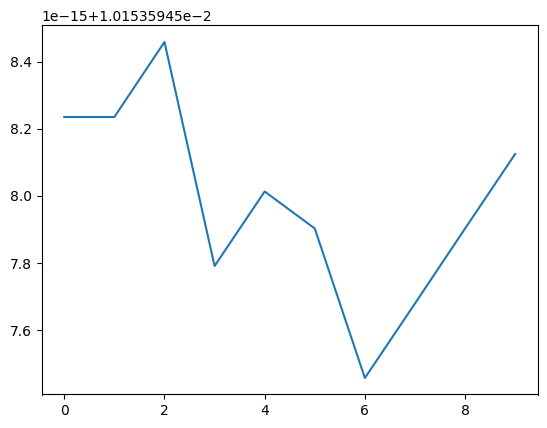

In [104]:
plt.plot(padded_data_01_X1_2[-1])

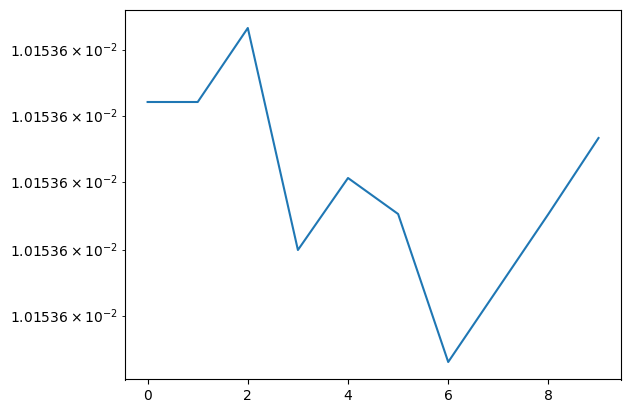

In [105]:
plt.semilogy(padded_data_01_X1_2[-1])

In [112]:
padded_data_01_X1_2[-1][-1]

0.010153594500368124

In [113]:
padded_data_01_X1_2[-1]

[0.010153594500368235,
 0.010153594500368235,
 0.010153594500368457,
 0.01015359450036779,
 0.010153594500368013,
 0.010153594500367902,
 0.010153594500367458,
 0.01015359450036768,
 0.010153594500367902,
 0.010153594500368124]

In [108]:
padded_data_01_X2_2 = pad_unitaries(results_dict[b]["X2"][n])

In [109]:
for _ in range(5):
    grad_descent_step_new(*padded_data_01_X2_2)

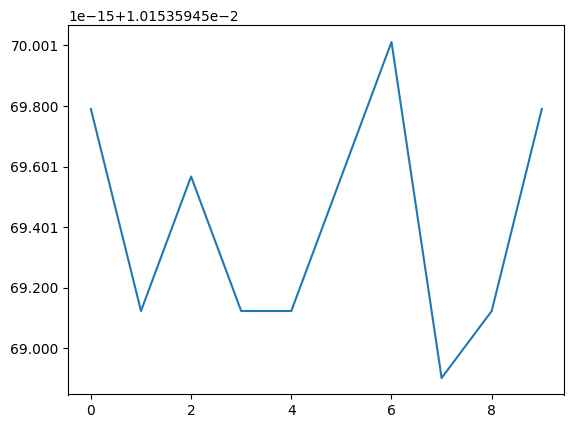

In [110]:
plt.plot(padded_data_01_X2_2[-1])

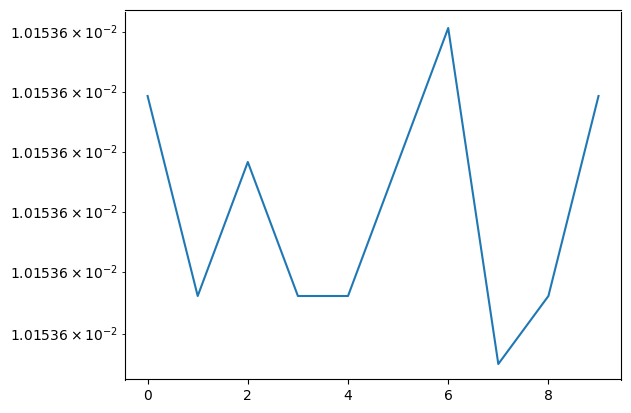

In [111]:
plt.semilogy(padded_data_01_X2_2[-1])

In [114]:
padded_data_01_X2_2[-1][-1]

0.01015359450036979

In [115]:
padded_data_01_X2_2[-1]

[0.01015359450036979,
 0.010153594500369123,
 0.010153594500369567,
 0.010153594500369123,
 0.010153594500369123,
 0.010153594500369567,
 0.010153594500370011,
 0.010153594500368901,
 0.010153594500369123,
 0.01015359450036979]

In [116]:
padded_data_01_X12_2 = pad_unitaries(results_dict[b]["X12"][n])

In [117]:
for _ in range(5):
    grad_descent_step_new(*padded_data_01_X12_2)

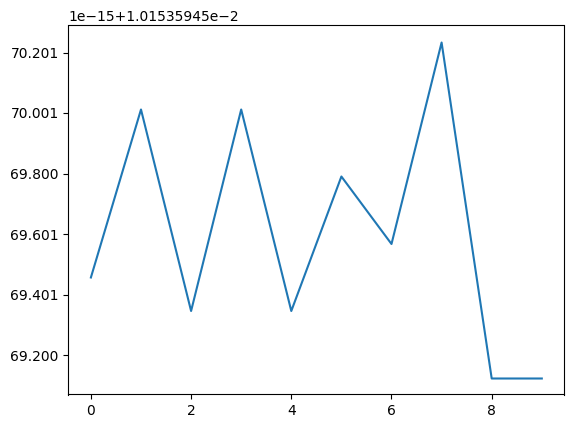

In [118]:
plt.plot(padded_data_01_X12_2[-1])

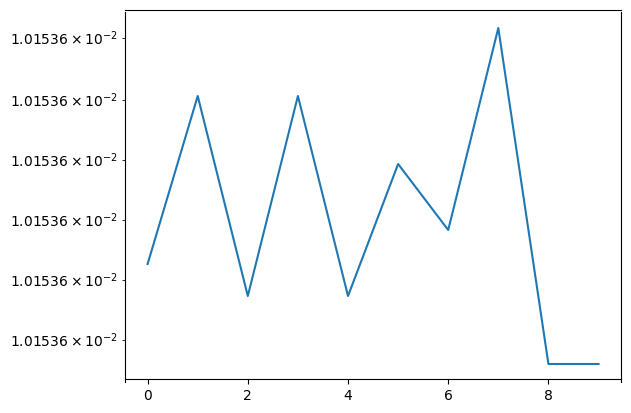

In [119]:
plt.semilogy(padded_data_01_X12_2[-1])

In [121]:
padded_data_01_X12_2[-1][-1]

0.010153594500369123

In [122]:
padded_data_01_X12_2[-1]

[0.010153594500369456,
 0.010153594500370011,
 0.010153594500369345,
 0.010153594500370011,
 0.010153594500369345,
 0.01015359450036979,
 0.010153594500369567,
 0.010153594500370233,
 0.010153594500369123,
 0.010153594500369123]

## B=0.2

In [77]:
b = 0.2

In [78]:
n=2

In [79]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [80]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

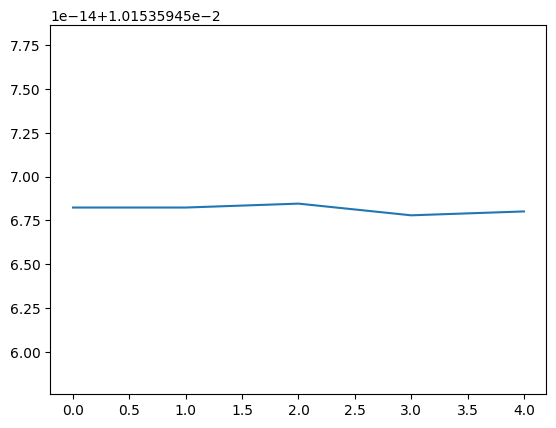

In [81]:
plt.plot(results_dict[b]["X1"][n][-1])

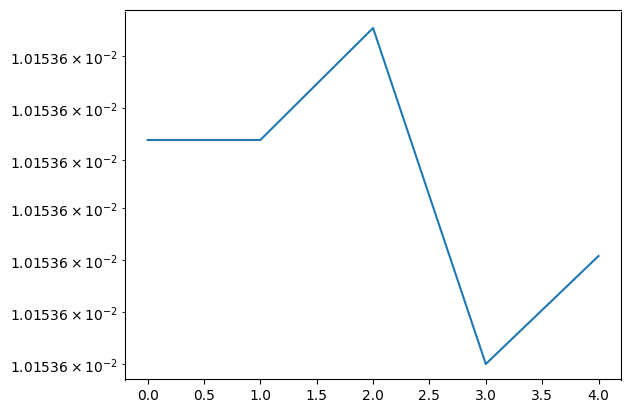

In [82]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [83]:
results_dict[b]["X1"][n][-1][-1]

0.010153594500368013

In [84]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

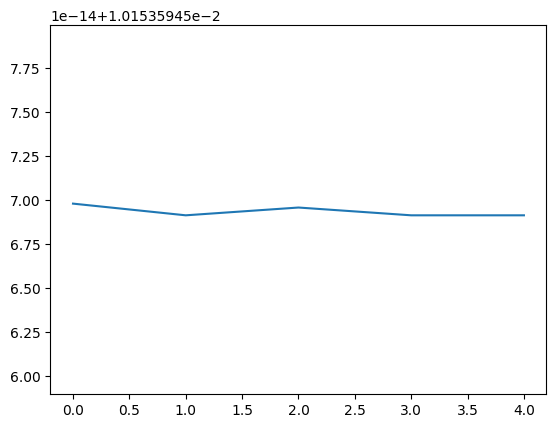

In [85]:
plt.plot(results_dict[b]["X2"][n][-1])

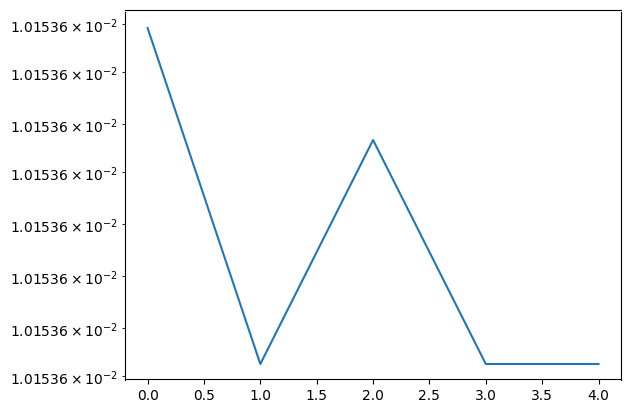

In [86]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [87]:
results_dict[b]["X2"][n][-1][-1]

0.010153594500369123

In [88]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

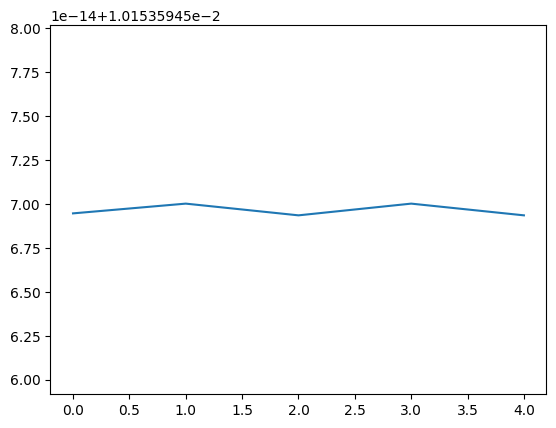

In [89]:
plt.plot(results_dict[b]["X12"][n][-1])

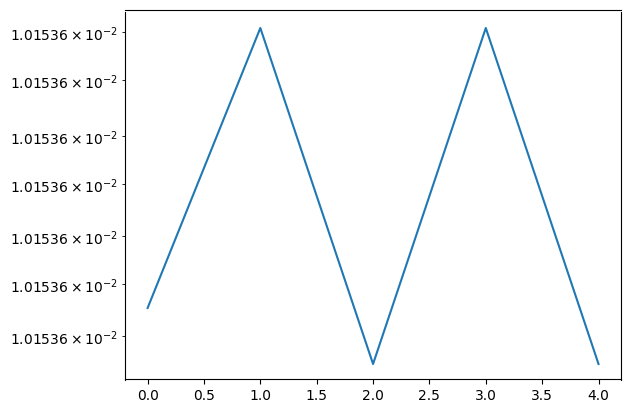

In [90]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [91]:
results_dict[b]["X12"][n][-1][-1]

0.010153594500369345

## B=0.3

In [321]:
b = 0.3

In [322]:
n=2

In [323]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [324]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

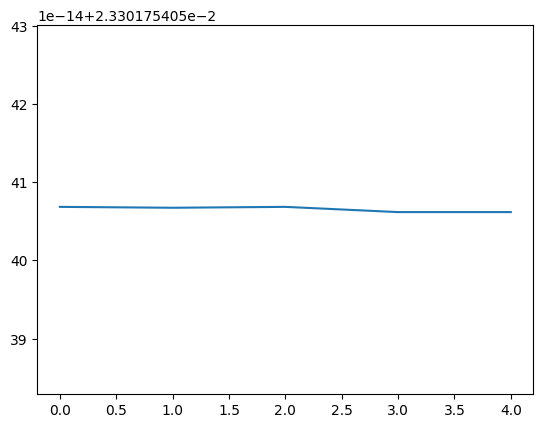

In [325]:
plt.plot(results_dict[b]["X1"][n][-1])

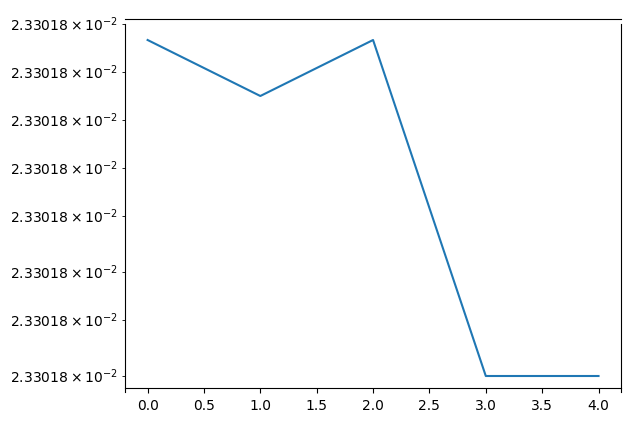

In [326]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [327]:
results_dict[b]["X1"][n][-1][-1]

0.0233017540524062

In [328]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

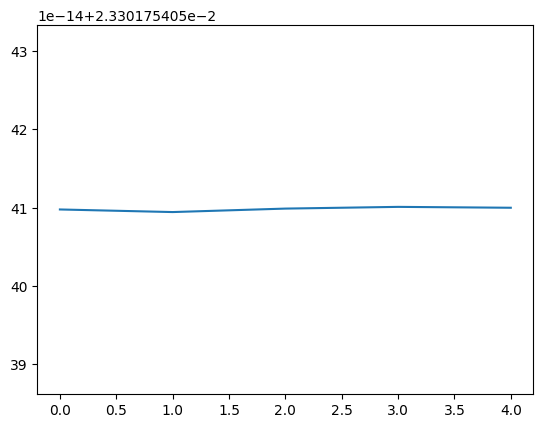

In [329]:
plt.plot(results_dict[b]["X2"][n][-1])

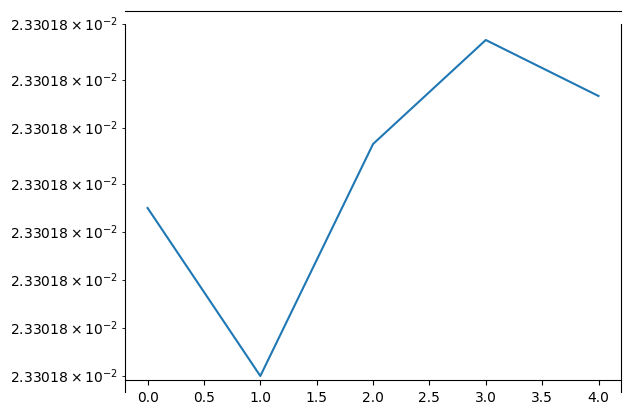

In [330]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [331]:
results_dict[b]["X2"][n][-1][-1]

0.023301754052409973

In [332]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

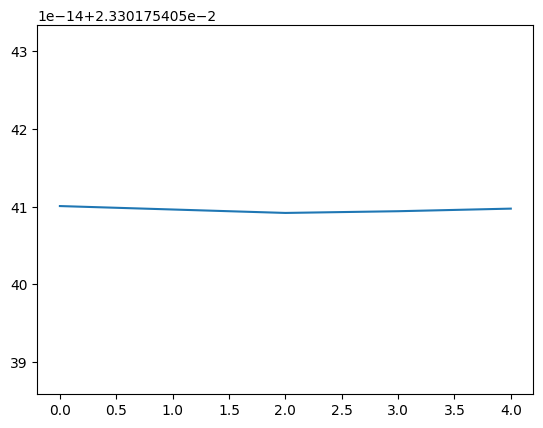

In [333]:
plt.plot(results_dict[b]["X12"][n][-1])

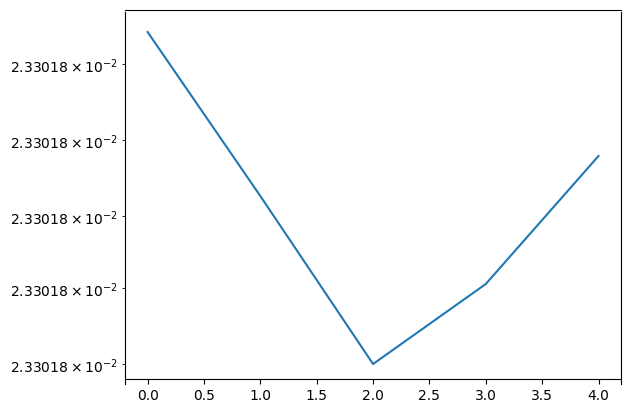

In [334]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [335]:
results_dict[b]["X12"][n][-1][-1]

0.02330175405240975

## B=0.4

In [336]:
b = 0.4

In [337]:
n=2

In [338]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [339]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

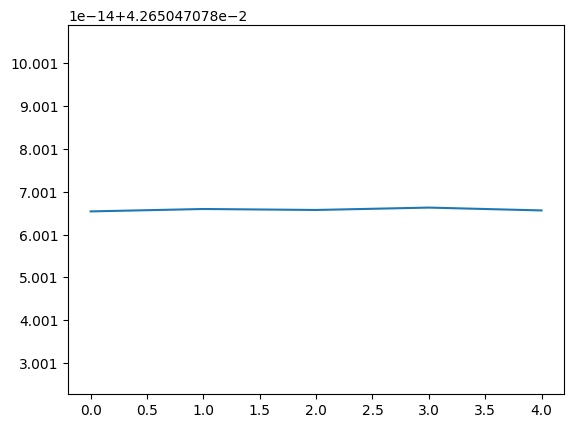

In [340]:
plt.plot(results_dict[b]["X1"][n][-1])

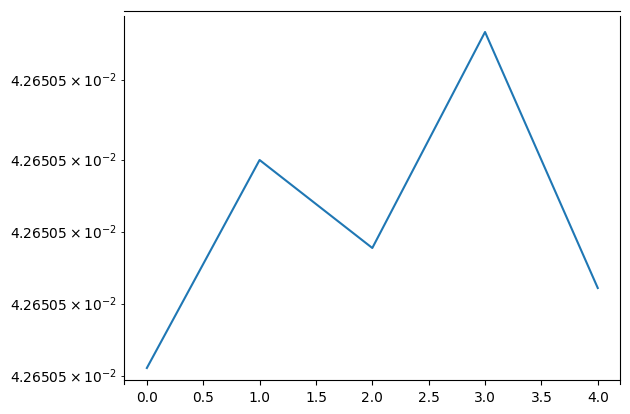

In [341]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [342]:
results_dict[b]["X1"][n][-1][-1]

0.04265047077606565

In [343]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

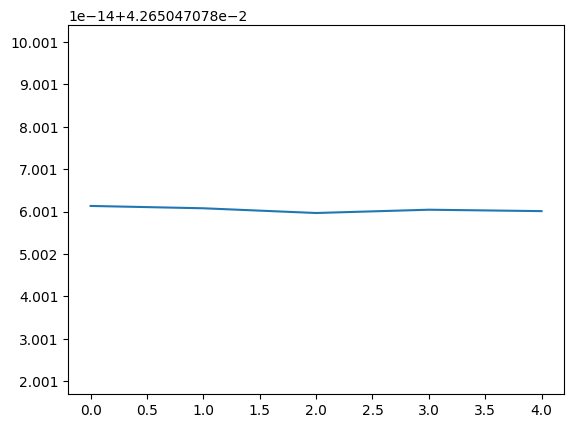

In [344]:
plt.plot(results_dict[b]["X2"][n][-1])

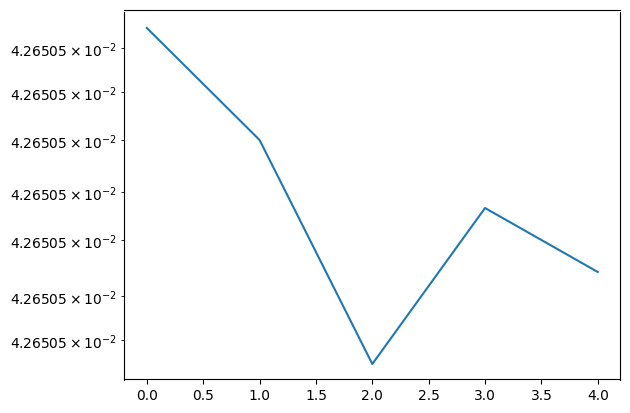

In [345]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [346]:
results_dict[b]["X2"][n][-1][-1]

0.0426504707760601

In [347]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

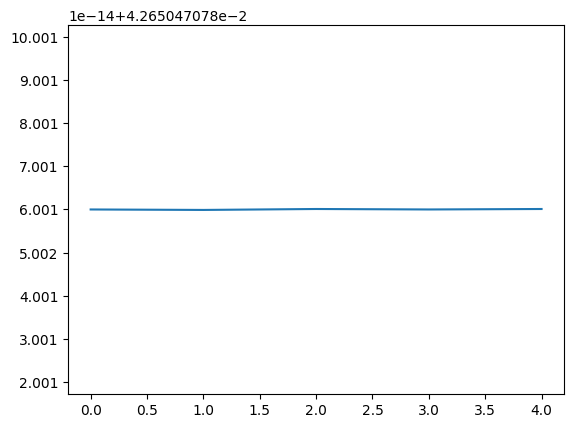

In [348]:
plt.plot(results_dict[b]["X12"][n][-1])

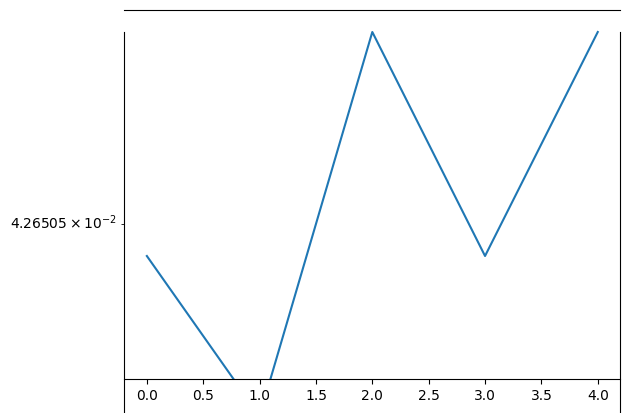

In [349]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [350]:
results_dict[b]["X12"][n][-1][-1]

0.0426504707760601

In [351]:
n=3

In [352]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [353]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

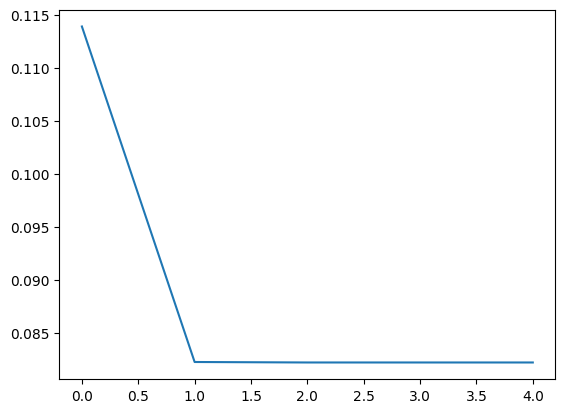

In [354]:
plt.plot(results_dict[b]["X1"][n][-1])

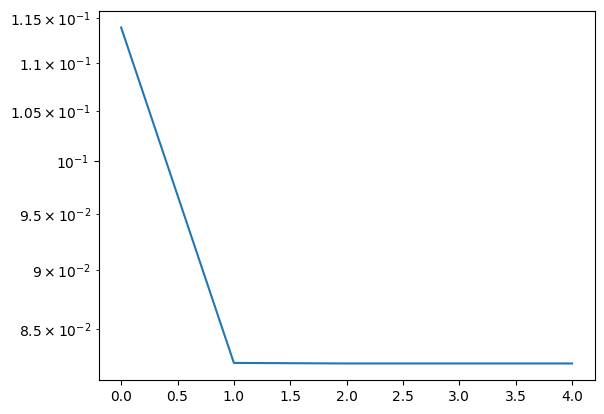

In [355]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [356]:
results_dict[b]["X1"][n][-1][-1]

0.08217696794233575

In [357]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

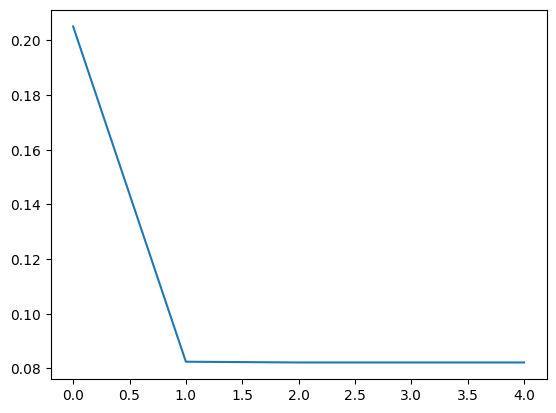

In [358]:
plt.plot(results_dict[b]["X2"][n][-1])

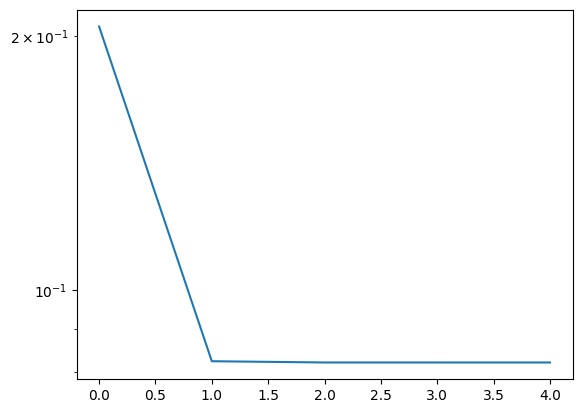

In [359]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [360]:
results_dict[b]["X2"][n][-1][-1]

0.08217696794357554

In [361]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

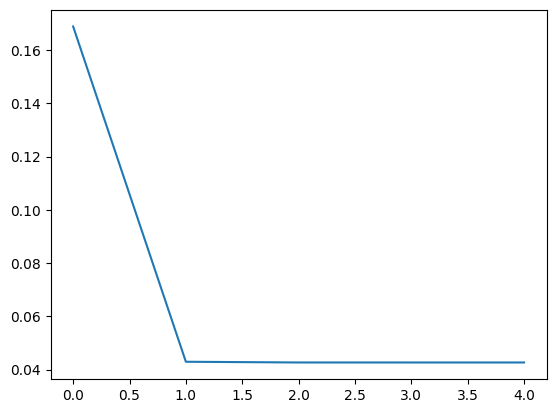

In [362]:
plt.plot(results_dict[b]["X12"][n][-1])

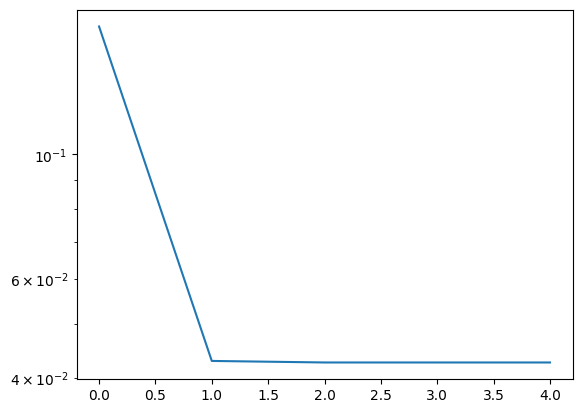

In [363]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [364]:
results_dict[b]["X12"][n][-1][-1]

0.04265047077748574

## B=0.5

In [365]:
b = 0.5

In [366]:
n=2

In [367]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [368]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

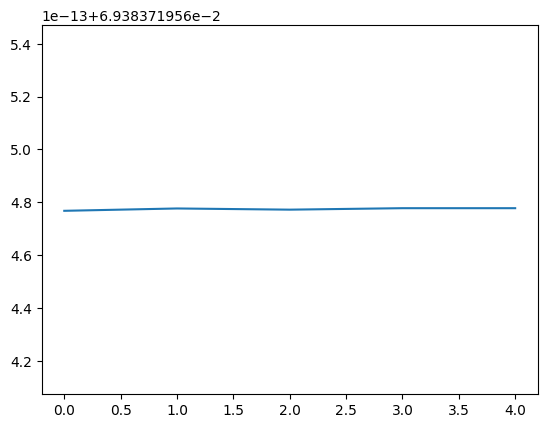

In [369]:
plt.plot(results_dict[b]["X1"][n][-1])

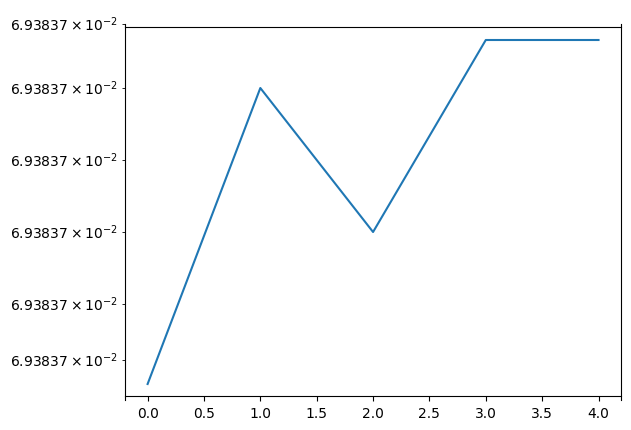

In [370]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [371]:
results_dict[b]["X1"][n][-1][-1]

0.06938371955547773

In [372]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

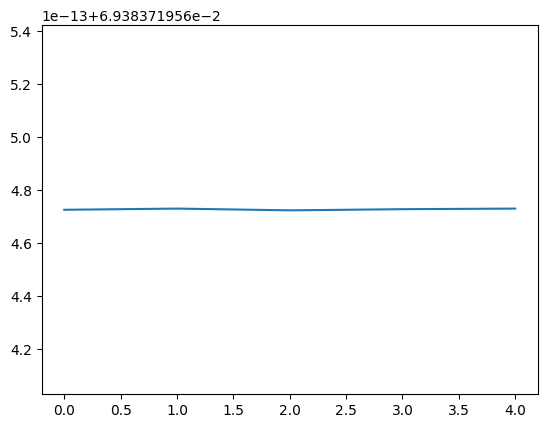

In [373]:
plt.plot(results_dict[b]["X2"][n][-1])

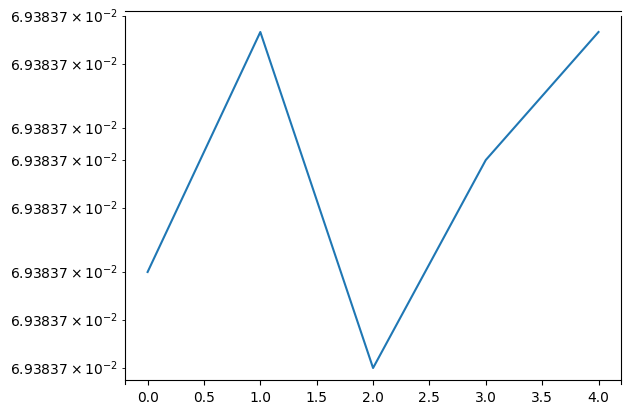

In [374]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [375]:
results_dict[b]["X2"][n][-1][-1]

0.06938371955547296

In [376]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

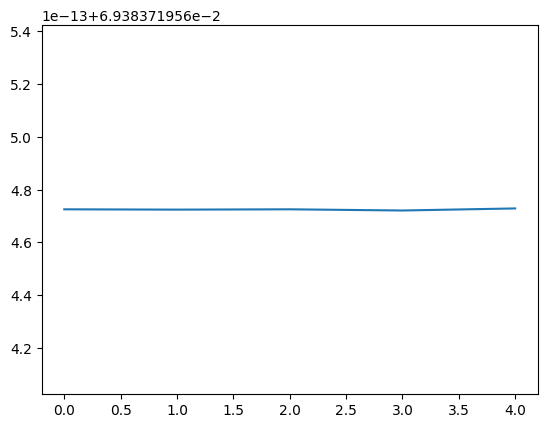

In [377]:
plt.plot(results_dict[b]["X12"][n][-1])

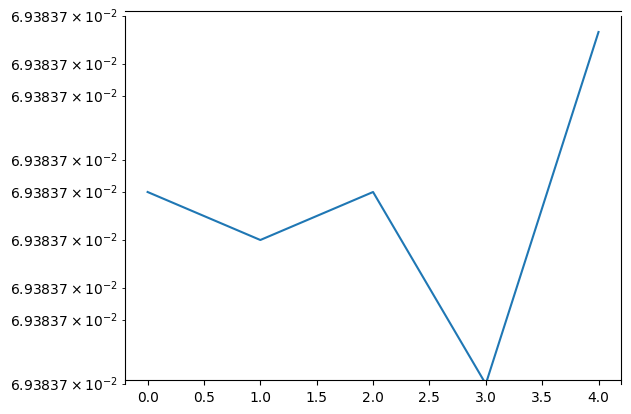

In [378]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [379]:
results_dict[b]["X12"][n][-1][-1]

0.06938371955547284

## B=0.6

In [380]:
b = 0.6

In [381]:
n=2

In [382]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [383]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

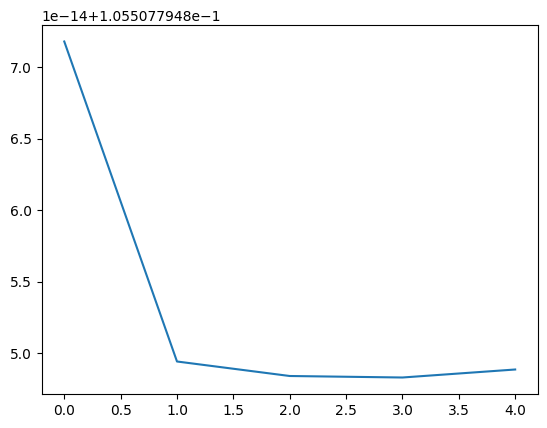

In [384]:
plt.plot(results_dict[b]["X1"][n][-1])

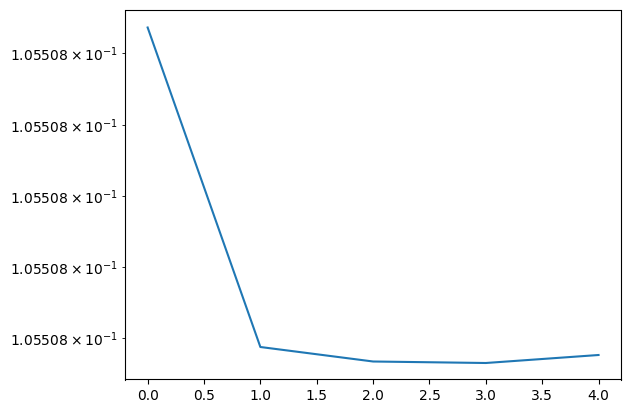

In [385]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [386]:
results_dict[b]["X1"][n][-1][-1]

0.10550779476194883

In [387]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

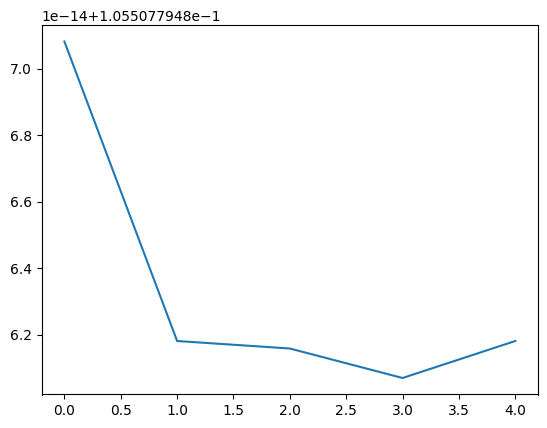

In [388]:
plt.plot(results_dict[b]["X2"][n][-1])

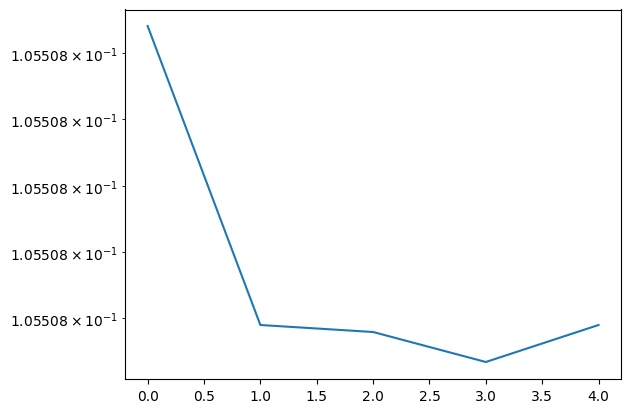

In [389]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [390]:
results_dict[b]["X2"][n][-1][-1]

0.10550779476196182

In [391]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

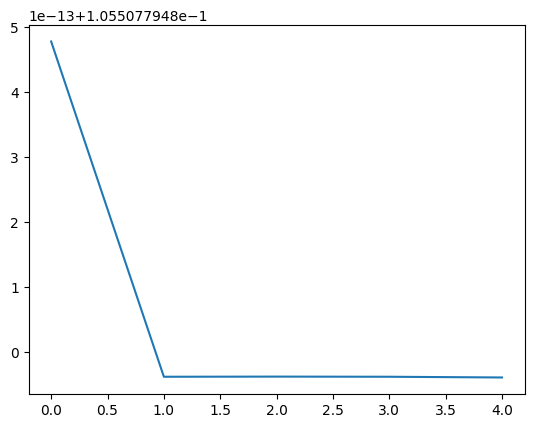

In [392]:
plt.plot(results_dict[b]["X12"][n][-1])

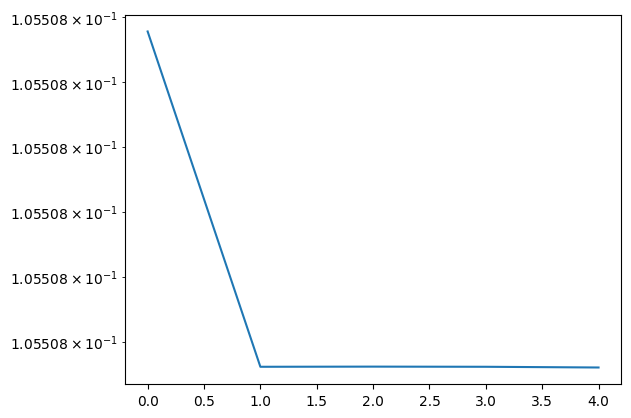

In [393]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [394]:
results_dict[b]["X12"][n][-1][-1]

0.10550779476196004

In [395]:
n=3

In [396]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [397]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

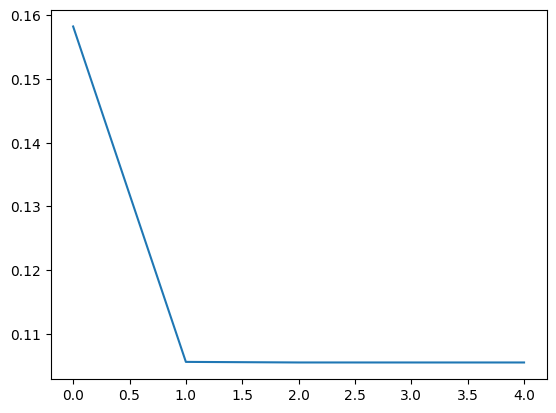

In [398]:
plt.plot(results_dict[b]["X1"][n][-1])

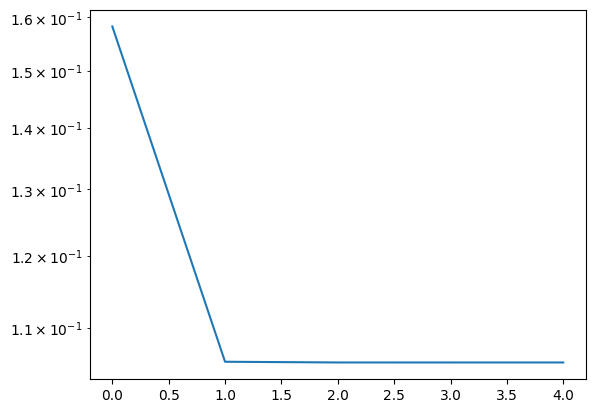

In [399]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [400]:
results_dict[b]["X1"][n][-1][-1]

0.10550779485240502

In [401]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

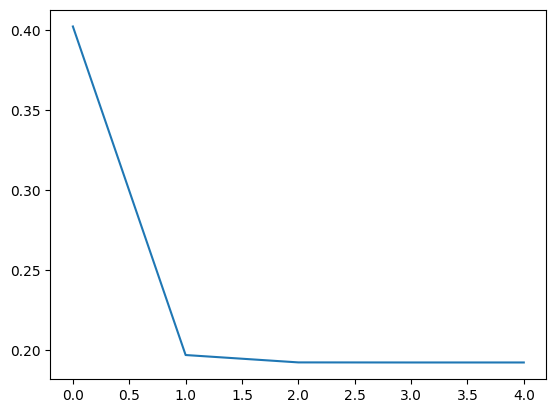

In [402]:
plt.plot(results_dict[b]["X2"][n][-1])

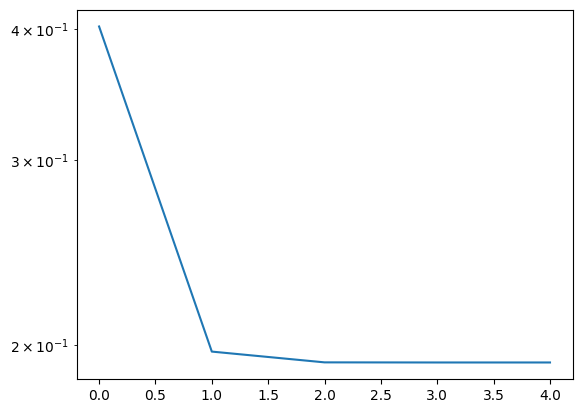

In [403]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [404]:
results_dict[b]["X2"][n][-1][-1]

0.19245777526433794

In [405]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

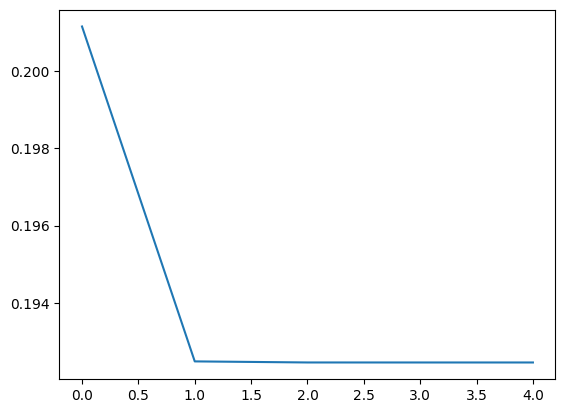

In [406]:
plt.plot(results_dict[b]["X12"][n][-1])

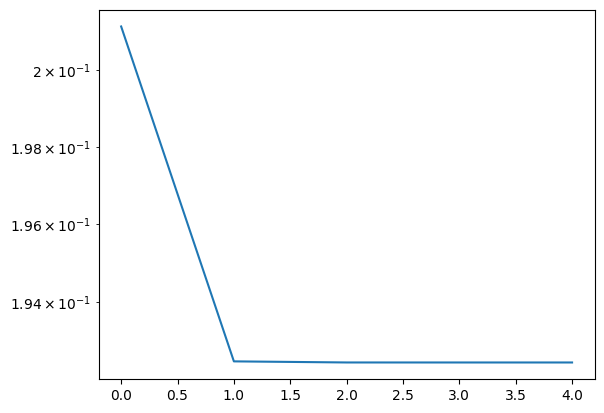

In [407]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [408]:
results_dict[b]["X12"][n][-1][-1]

0.1924577706856926

In [410]:
n=20

In [411]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)[:-1]

In [416]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X1"][n])

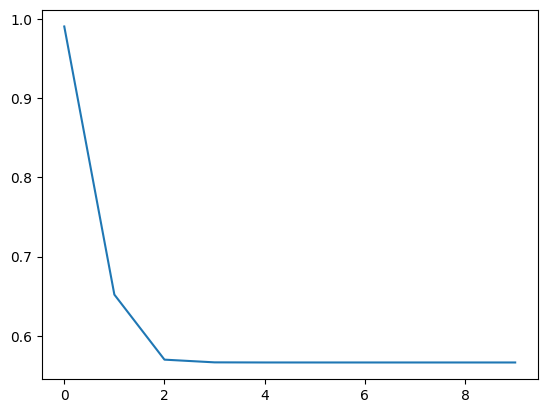

In [417]:
plt.plot(results_dict[b]["X1"][n][-1])

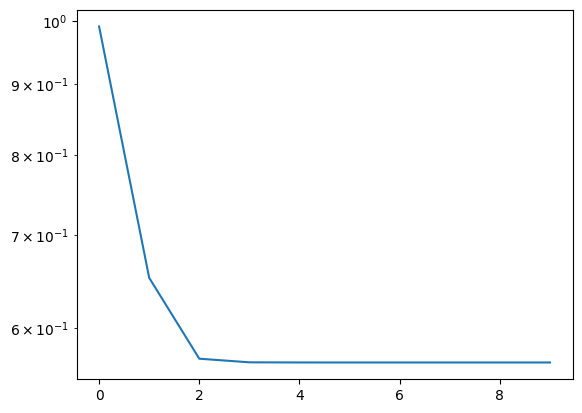

In [418]:
plt.semilogy(results_dict[b]["X1"][n][-1])

In [419]:
results_dict[b]["X1"][n][-1][-1]

0.566264399317981

In [420]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X2"][n])

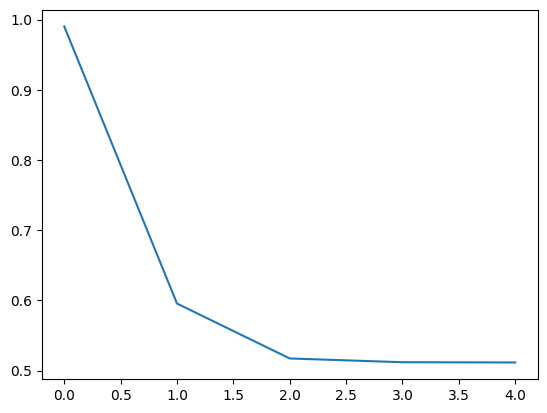

In [421]:
plt.plot(results_dict[b]["X2"][n][-1])

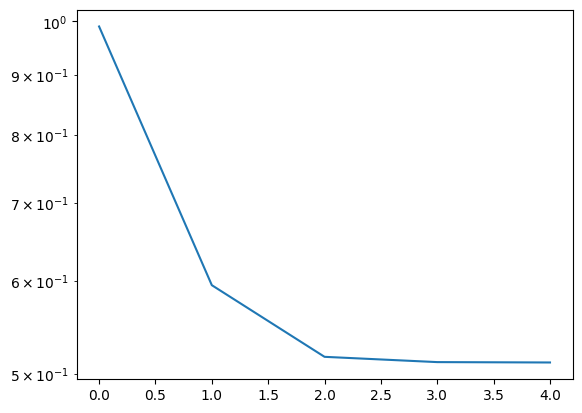

In [422]:
plt.semilogy(results_dict[b]["X2"][n][-1])

In [423]:
results_dict[b]["X2"][n][-1][-1]

0.5114921465079603

In [424]:
for _ in range(5):
    grad_descent_step_new(*results_dict[b]["X12"][n])

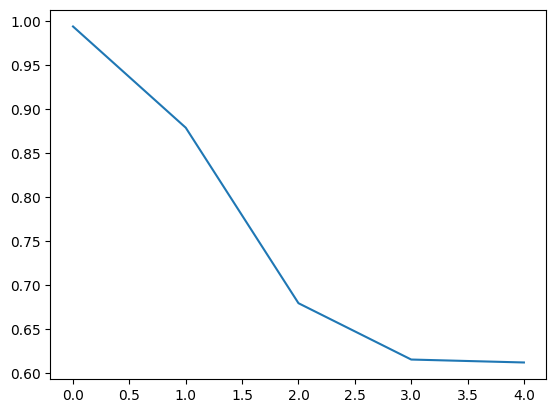

In [425]:
plt.plot(results_dict[b]["X12"][n][-1])

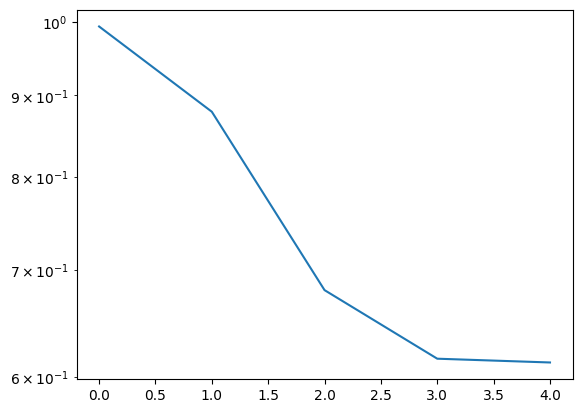

In [426]:
plt.semilogy(results_dict[b]["X12"][n][-1])

In [427]:
results_dict[b]["X12"][n][-1][-1]

0.6124391773655664

## B=0.6

In [211]:
b = 0.6

In [231]:
n=3

In [213]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)

In [214]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X1"][n], eta=0.1)

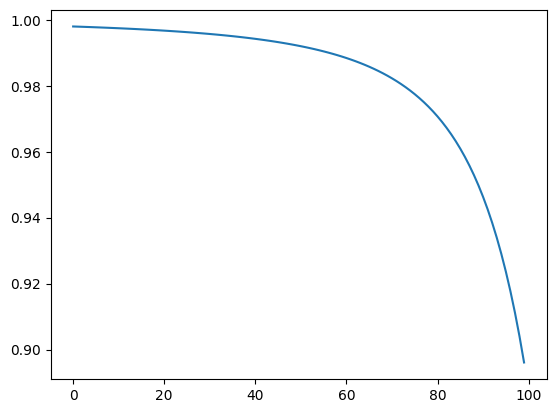

In [215]:
plt.plot(results_dict[b]["X1"][n][-2])

In [137]:
(results_dict[b]["X1"][n][-2][-1], results_dict[b]["X1"][n][-1][-1])

(0.10316833512941004, 0.0016438202908179989)

In [138]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X2"][n], eta=0.1)

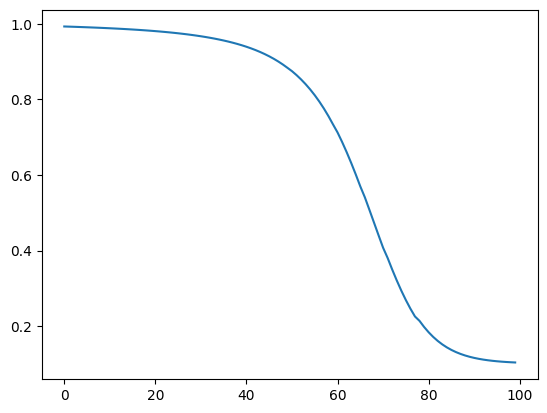

In [139]:
plt.plot(results_dict[b]["X2"][n][-2])

In [140]:
(results_dict[b]["X2"][n][-2][-1], results_dict[b]["X2"][n][-1][-1])

(0.10351210761355512, 0.0037994992243028936)

In [141]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X12"][n], eta=0.1)

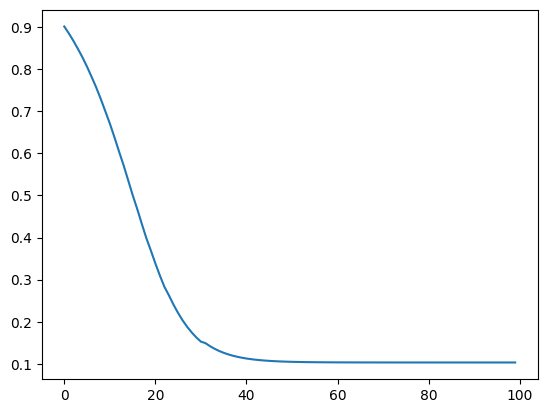

In [142]:
plt.plot(results_dict[b]["X12"][n][-2])

In [143]:
(results_dict[b]["X12"][n][-2][-1], results_dict[b]["X12"][n][-1][-1])

(0.10345861013466573, 0.0019593601568477226)

### n=3
Increase width

In [144]:
n=3

In [145]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)

In [149]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X1"][n], eta=0.1)

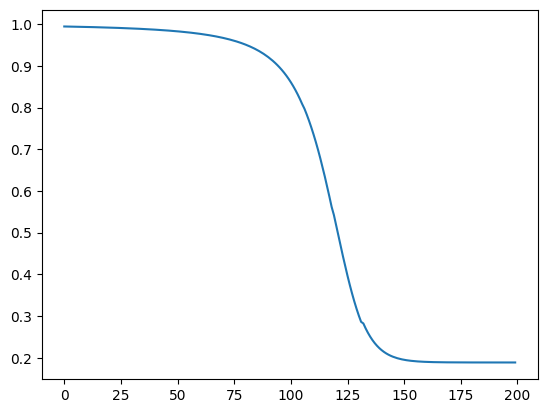

In [150]:
plt.plot(results_dict[b]["X1"][n][-2])

In [151]:
(results_dict[b]["X1"][n][-2][-1], results_dict[b]["X1"][n][-1][-1])

(0.18869712232838443, 0.001884560916140865)

In [152]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X2"][n], eta=0.1)

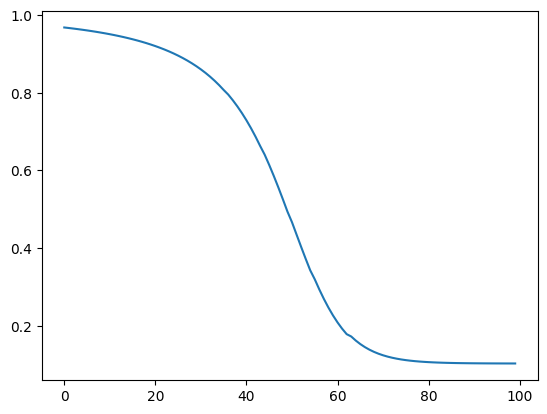

In [153]:
plt.plot(results_dict[b]["X2"][n][-2])

In [154]:
(results_dict[b]["X2"][n][-2][-1], results_dict[b]["X2"][n][-1][-1])

(0.1025199958773485, 0.002554812369092163)

In [155]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X12"][n], eta=0.1)

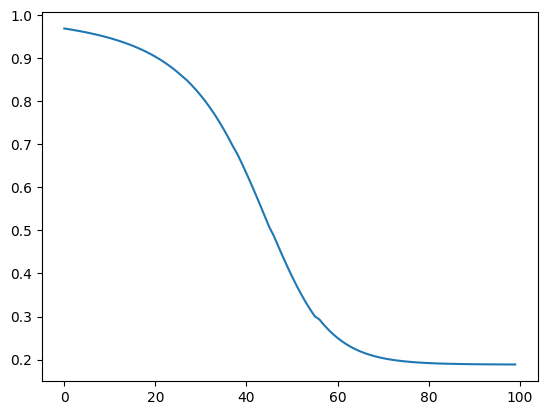

In [156]:
plt.plot(results_dict[b]["X12"][n][-2])

In [157]:
(results_dict[b]["X12"][n][-2][-1], results_dict[b]["X12"][n][-1][-1])

(0.1885013704127978, 0.002369111375567279)

### n=4
Increase width

In [158]:
n=4

In [159]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)

In [166]:
for _ in range(100):
    grad_descent_step(*results_dict[b]["X1"][n], eta=0.1)

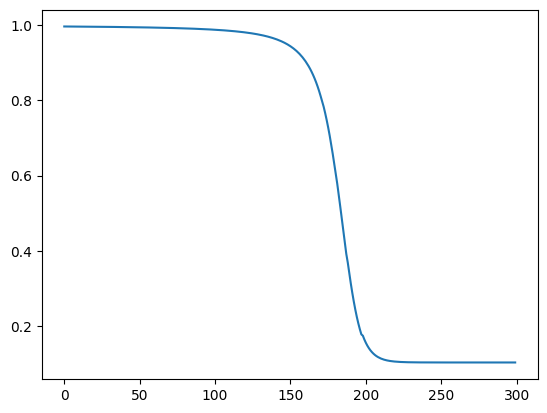

In [167]:
plt.plot(results_dict[b]["X1"][n][-2])

In [168]:
(results_dict[b]["X1"][n][-2][-1], results_dict[b]["X1"][n][-1][-1])

(0.10233372796445206, 0.001876633497130964)

In [169]:
for _ in range(300):
    grad_descent_step(*results_dict[b]["X2"][n], eta=0.1)

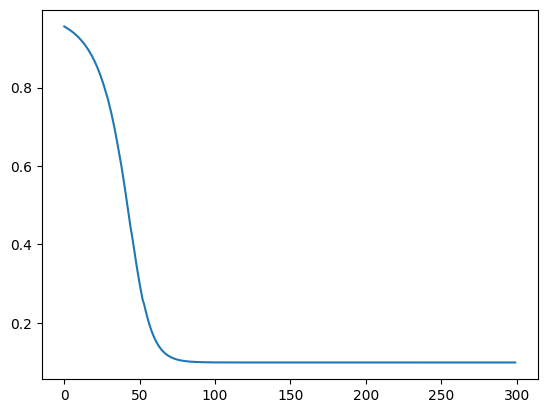

In [170]:
plt.plot(results_dict[b]["X2"][n][-2])

In [171]:
(results_dict[b]["X2"][n][-2][-1], results_dict[b]["X2"][n][-1][-1])

(0.09895776194874029, 0.004318257984762042)

In [175]:
for _ in range(300):
    grad_descent_step(*results_dict[b]["X12"][n], eta=0.1)

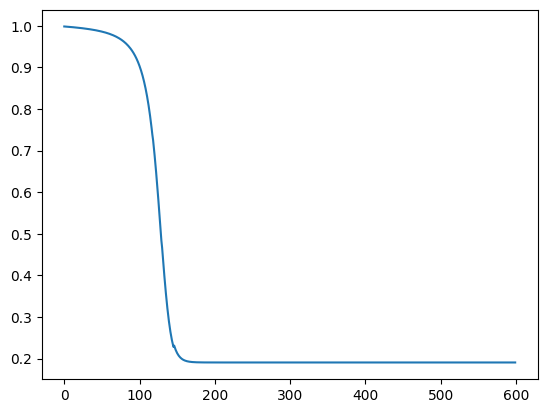

In [176]:
plt.plot(results_dict[b]["X12"][n][-2])

In [177]:
(results_dict[b]["X12"][n][-2][-1], results_dict[b]["X12"][n][-1][-1])

(0.19082751687357402, 0.0008282858887507238)

### n=5
Increase width

In [178]:
n=5

In [179]:
for g, u in symmetry_actions.items():
    results_dict[b][g][n] = grad_descent_setup(psi_dict[b], n, u)

In [183]:
for _ in range(200):
    grad_descent_step(*results_dict[b]["X1"][n], eta=0.1)

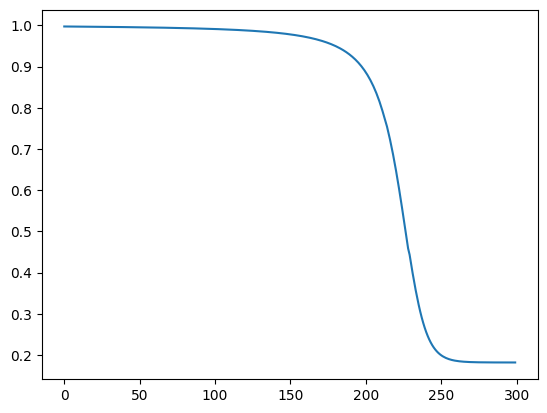

In [184]:
plt.plot(results_dict[b]["X1"][n][-2])

In [185]:
(results_dict[b]["X1"][n][-2][-1], results_dict[b]["X1"][n][-1][-1])

(0.18198017300553992, 0.0039911646226022945)

In [189]:
for _ in range(300):
    grad_descent_step(*results_dict[b]["X2"][n], eta=0.1)

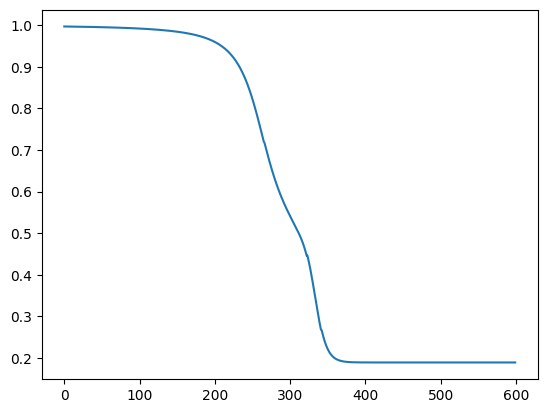

In [190]:
plt.plot(results_dict[b]["X2"][n][-2])

In [191]:
(results_dict[b]["X2"][n][-2][-1], results_dict[b]["X2"][n][-1][-1])

(0.18937437152979708, 0.00240452933392743)

In [195]:
for _ in range(400):
    grad_descent_step(*results_dict[b]["X12"][n], eta=0.1)

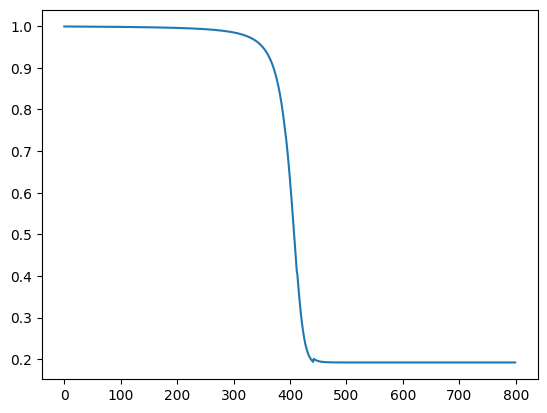

In [196]:
plt.plot(results_dict[b]["X12"][n][-2])

In [197]:
(results_dict[b]["X12"][n][-2][-1], results_dict[b]["X12"][n][-1][-1])

(0.19210841354039232, 0.00034411642823961586)

## Test on other wavefunctions
### B=0.1

In [96]:
psi_b01 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.1
)   

In [97]:
data_b01_sl = grad_descent_setup(psi_b01, 2, [np_X, np_I]*20)

In [98]:
for _ in range(200):
    grad_descent_step(*data_b01_sl, eta=0.1)

In [99]:
(*_, losses, unitary_scores) = data_b01_sl

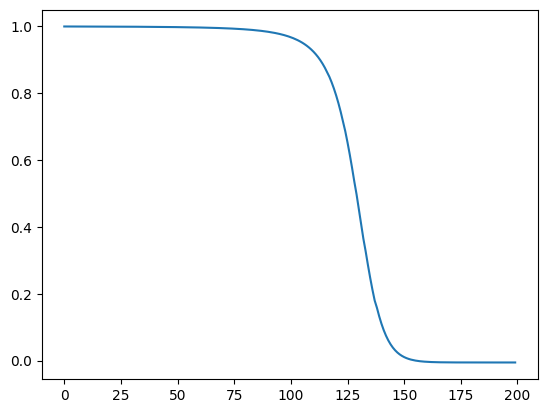

In [100]:
plt.plot(losses)

In [101]:
losses[-1]

-0.005618972178154991

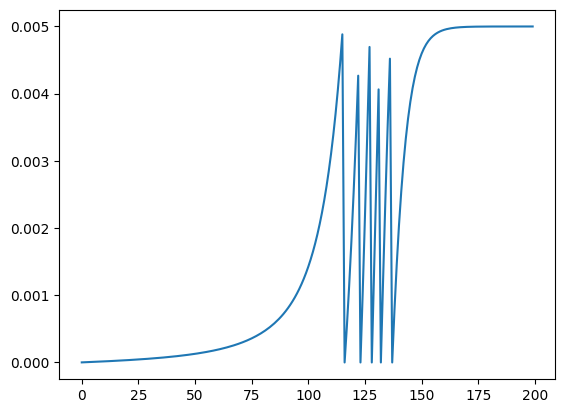

In [102]:
plt.plot(unitary_scores)

In [103]:
data_b01_sr = grad_descent_setup(psi_b01, 2, [np_I, np_X]*20)

In [104]:
for _ in range(200):
    grad_descent_step(*data_b01_sr, eta=0.1)

In [105]:
(*_, losses, unitary_scores) = data_b01_sr

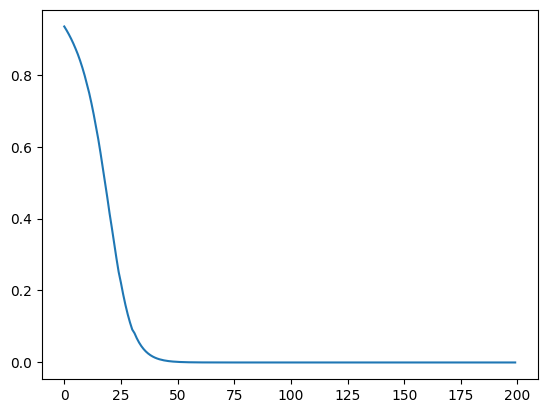

In [106]:
plt.plot(losses)

In [107]:
losses[-1]

-0.0015666398602185438

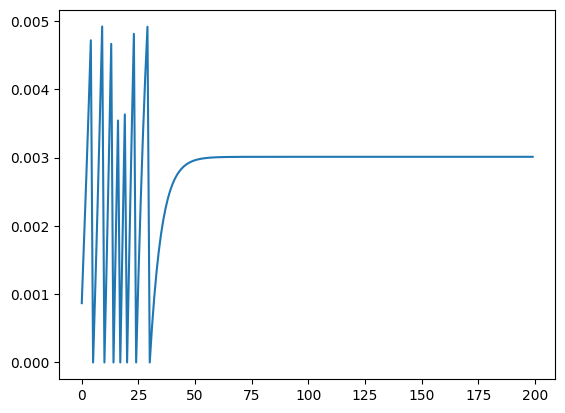

In [108]:
plt.plot(unitary_scores)

In [109]:
data_b01_sb = grad_descent_setup(psi_b01, 2, [np_X, np_X]*20)

In [110]:
for _ in range(300):
    grad_descent_step(*data_b01_sb, eta=0.1)

In [111]:
(*_, losses, unitary_scores) = data_b01_sb

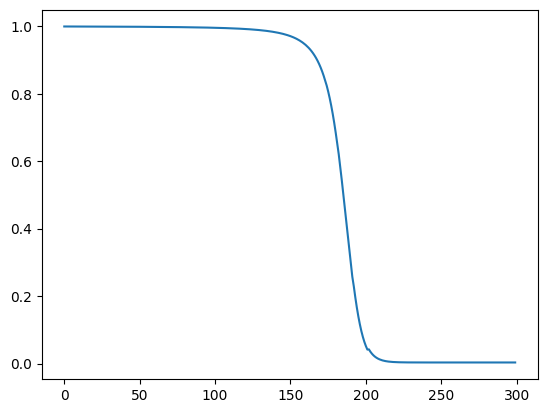

In [112]:
plt.plot(losses)

In [113]:
losses[-1]

0.0030780552672892147

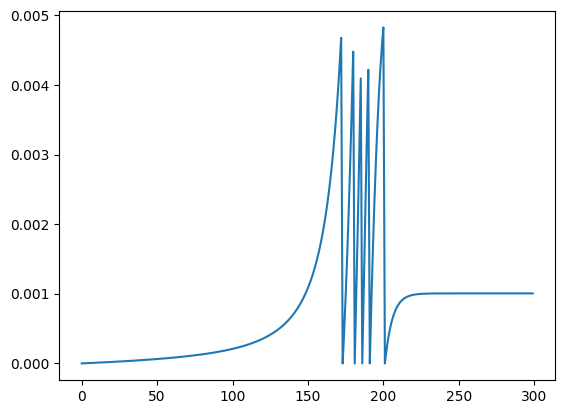

In [114]:
plt.plot(unitary_scores)

In [115]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sr[3],
    data_b01_sl[4],
    data_b01_sr[4]
)

((-1-2.7665089151433557e-17j), (-1-2.7560688805525257e-17j))

In [116]:
extract_left_right_cohomology_phases(
    data_b01_sl[3],
    data_b01_sb[3],
    data_b01_sl[4],
    data_b01_sb[4]
)

((-1-6.227666357626422e-17j), (-1+4.1385487841061484e-17j))

In [117]:
extract_left_right_cohomology_phases(
    data_b01_sr[3],
    data_b01_sb[3],
    data_b01_sr[4],
    data_b01_sb[4]
)

((-1+4.1538137462877705e-17j), (-1+8.310067974360291e-17j))

### B=0.5

In [118]:
b_parameters = list(d['paramters']['B'] for d in loaded_data)

In [119]:
b_parameters

[1.3,
 0.4,
 1.7000000000000002,
 1.6,
 0.1,
 1.9000000000000001,
 1.2000000000000002,
 1.8,
 1.4000000000000001,
 2.0,
 0.6000000000000001,
 0.5,
 0.30000000000000004,
 1.5,
 0.9,
 0.7000000000000001,
 0.2,
 0.0,
 1.1,
 0.8,
 1.0]

That's annoying...

In [120]:
psi_05 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.5
)   

In [121]:
data_b05_sl_w2 = grad_descent_setup(psi_05, 2, [np_X, np_I]*20)

In [122]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [123]:
(*_, losses, unitary_scores) = data_b05_sl_w2

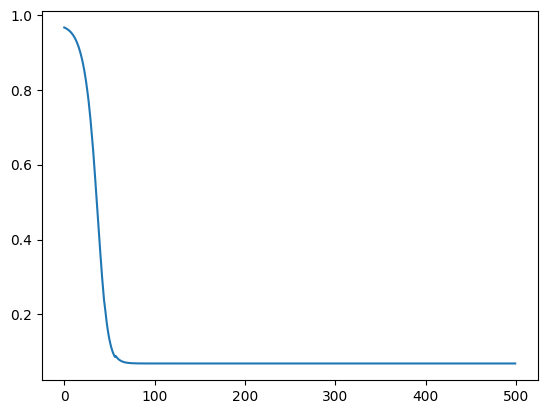

In [124]:
plt.plot(losses)

In [125]:
losses[-1]

0.06845781490598868

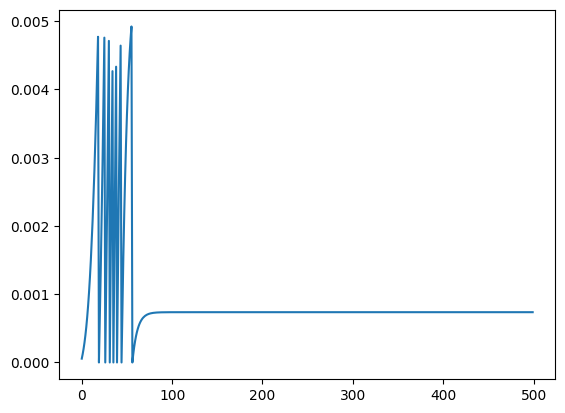

In [126]:
plt.plot(unitary_scores)

In [127]:
data_b05_sr_w2 = grad_descent_setup(psi_05, 2, [np_I, np_X]*20)

In [128]:
for _ in range(500):
    grad_descent_step(*data_b05_sr_w2, eta=0.1)

In [129]:
(*_, losses, unitary_scores) = data_b05_sr_w2

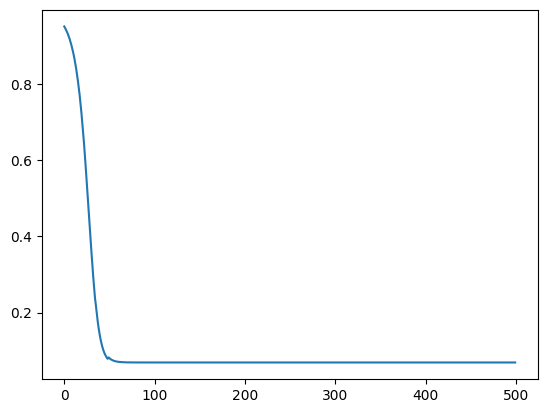

In [130]:
plt.plot(losses)

In [131]:
losses[-1]

0.06876288847406586

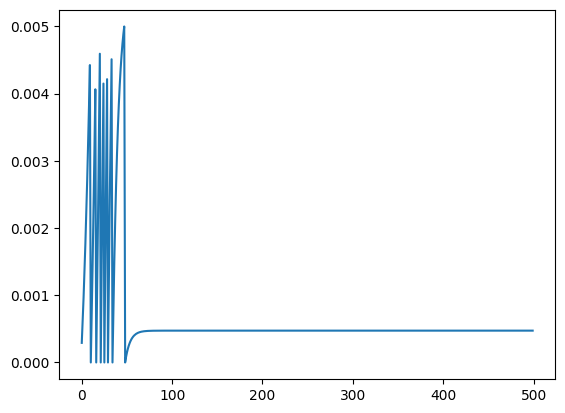

In [132]:
plt.plot(unitary_scores)

In [133]:
data_b05_sb_w2 = grad_descent_setup(psi_05, 2, [np_X, np_X]*20)

In [134]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w2, eta=0.1)

In [135]:
(*_, losses, unitary_scores) = data_b05_sb_w2

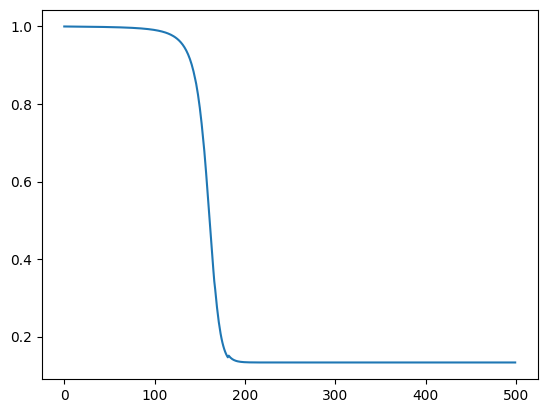

In [136]:
plt.plot(losses)

In [137]:
losses[-1]

0.1331960501603381

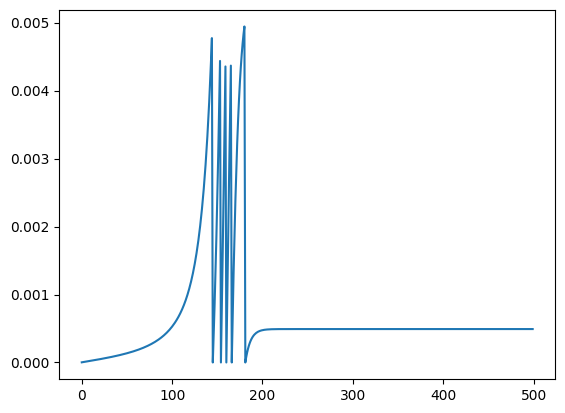

In [138]:
plt.plot(unitary_scores)

This loss doesn't seem to decrease if the unitary wdith is increased...

In [139]:
data_b05_sb_w4 = grad_descent_setup(psi_05, 4, [np_X, np_X]*20)

In [140]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w4, eta=0.1)

In [141]:
(*_, losses, unitary_scores) = data_b05_sb_w4

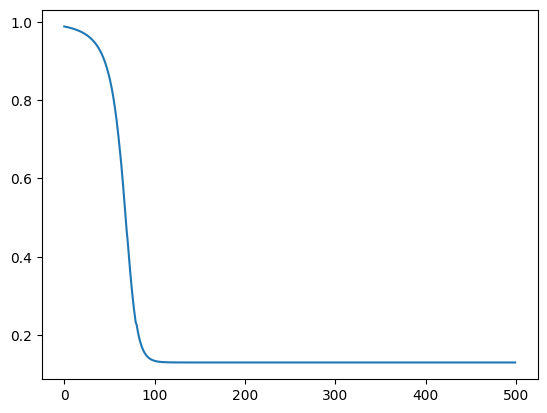

In [142]:
plt.plot(losses)

In [143]:
(losses[-1], unitary_scores[-1])

(0.1297777297120658, 0.002149092853471979)

In [144]:
data_b05_sb_w8 = grad_descent_setup(psi_05, 8, [np_X, np_X]*20)

In [153]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w8, eta=1)

In [154]:
(*_, losses, unitary_scores) = data_b05_sb_w8

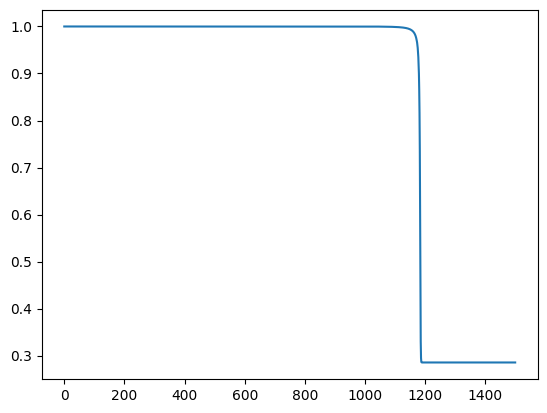

In [155]:
plt.plot(losses)

In [156]:
(losses[-1], unitary_scores[-1])

(0.2853518722284043, 0.001142864456302073)

In [297]:
data_b05_sb_w16 = grad_descent_setup(psi_05, 16, [np_X, np_X]*20)

In [298]:
loss = 1
while loss > 0.5:
    grad_descent_step(*data_b05_sb_w16, eta=20)
    (*_, losses, _) = data_b05_sb_w16
    loss = losses[-1]

In [301]:
for _ in range(500):
    grad_descent_step(*data_b05_sb_w16, eta=0.1)

In [302]:
(*_, losses, unitary_scores) = data_b05_sb_w16

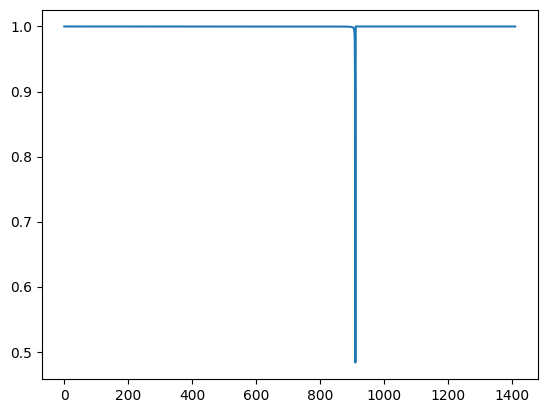

In [303]:
plt.plot(losses)

...huh

In [296]:
(losses[-1], unitary_scores[-1])

(0.47669019099449705, 1.1102230246251565e-15)

In [291]:
min(losses)

0.4023472865754024

Extract cohomology phases

In [234]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sr_w2[3],
    data_b05_sl_w2[4],
    data_b05_sr_w2[4]
)

((-1-1.383392213069203e-17j), (-1+1.1032504551845488e-16j))

In [235]:
extract_left_right_cohomology_phases(
    data_b05_sl_w2[3],
    data_b05_sb_w2[3],
    data_b05_sl_w2[4],
    data_b05_sb_w2[4]
)

((-1-8.289942759960176e-17j), (-1+0j))

In [236]:
extract_left_right_cohomology_phases(
    data_b05_sr_w2[3],
    data_b05_sb_w2[3],
    data_b05_sr_w2[4],
    data_b05_sb_w2[4]
)

((-1-1.0380662306880248e-16j), (-1+1.1060006166619062e-16j))

Not using this code anymore...
Add more unitaries, and continue learning.

In [314]:
left_unitaries = data_b05_sl_w2[3].copy()
right_unitaries = data_b05_sl_w2[4].copy()

In [315]:
identity_matrix = np.array([[1,0], [0,1]], dtype='complex128')

In [316]:
left_unitaries = [identity_matrix,] + left_unitaries
right_unitaries.append(identity_matrix)

In [317]:
len(left_unitaries), len(right_unitaries)

(3, 3)

In [321]:
padded_data_b05_sl_w3 = (
    data_b05_sl_w2[:3] +
    (left_unitaries, right_unitaries) +
    (starting_index - 1,) +
    data_b05_sl_w2[6:]
)

In [322]:
len(padded_data_b05_sl_w3) == len(data_b05_sl_w2)

True

In [323]:
for _ in range(500):
    grad_descent_step(*padded_data_b05_sl_w3, eta=0.1)

In [324]:
(*_, losses, unitary_scores) = padded_data_b05_sl_w3

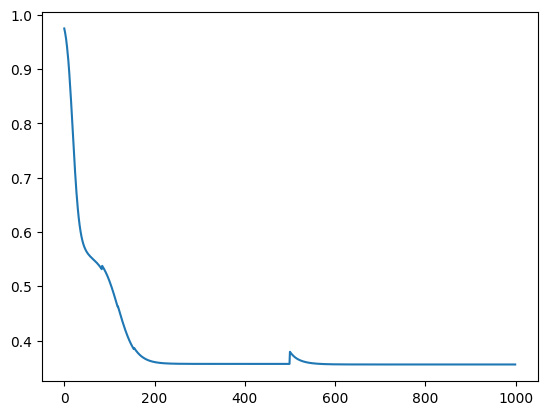

In [325]:
plt.plot(losses)

In [326]:
losses[-1]

0.35584537647591674

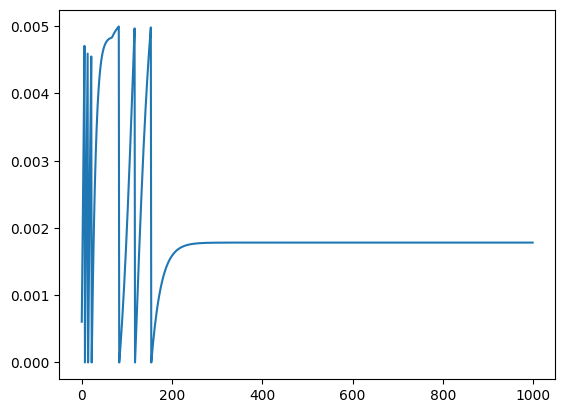

In [327]:
plt.plot(unitary_scores)

No improvement, so start again

In [307]:
data_b05_sl_w3 = grad_descent_setup(test_psi, 2, [np_X, np_I]*20)

In [309]:
for _ in range(500):
    grad_descent_step(*data_b05_sl_w2, eta=0.1)

In [310]:
(*_, losses, unitary_scores) = data_b05_sl_w2

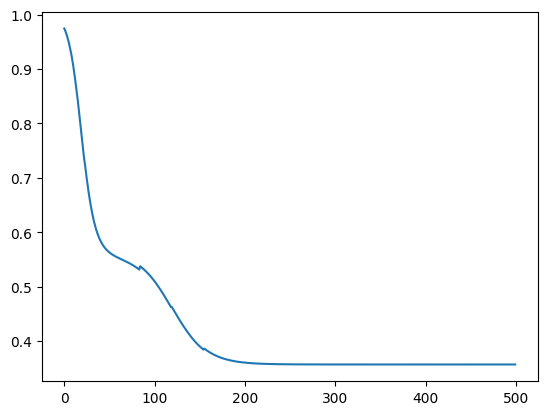

In [311]:
plt.plot(losses)

In [312]:
losses[-1]

0.35690881649743733

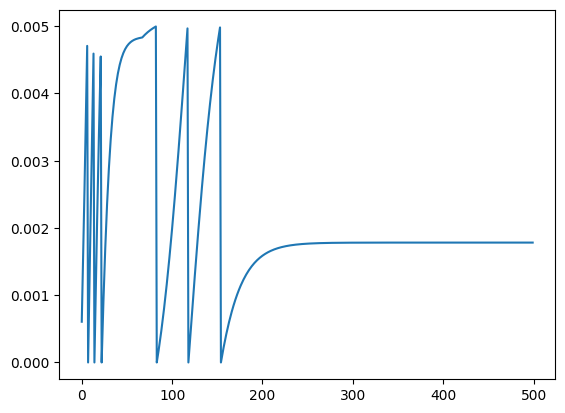

In [313]:
plt.plot(unitary_scores)

### B=0.9

In [237]:
psi_09 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 0.9
)   

In [238]:
data_b09_sl_w2 = grad_descent_setup(psi_09, 2, [np_X, np_I]*30)

In [239]:
for _ in range(500):
    grad_descent_step(*data_b09_sl_w2, eta=0.1)

In [240]:
(*_, losses, unitary_scores) = data_b09_sl_w2

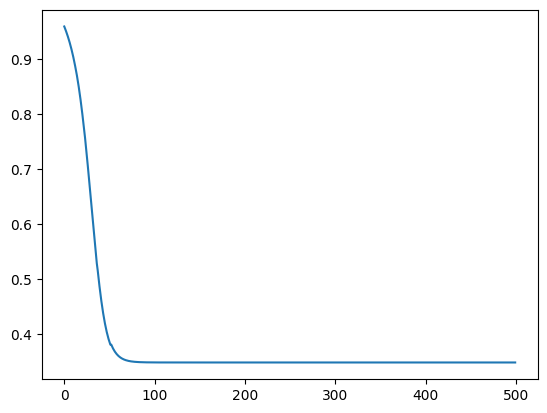

In [241]:
plt.plot(losses)

In [242]:
(losses[-1], unitary_scores[-1])

(0.34903122407072773, 0.0011358450623486505)

In [243]:
data_b09_sr_w2 = grad_descent_setup(psi_09, 2, [np_I, np_X]*30)

In [244]:
for _ in range(500):
    grad_descent_step(*data_b09_sr_w2, eta=0.1)

In [245]:
(*_, losses, unitary_scores) = data_b09_sr_w2

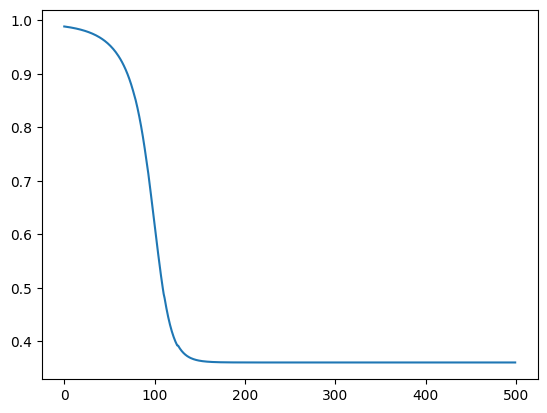

In [246]:
plt.plot(losses)

In [247]:
(losses[-1], unitary_scores[-1])

(0.3606021342416814, 0.002057565319054655)

In [248]:
data_b09_sb_w2 = grad_descent_setup(psi_09, 2, [np_X, np_X]*30)

In [249]:
for _ in range(500):
    grad_descent_step(*data_b09_sb_w2, eta=0.1)

In [250]:
(*_, losses, unitary_scores) = data_b09_sb_w2

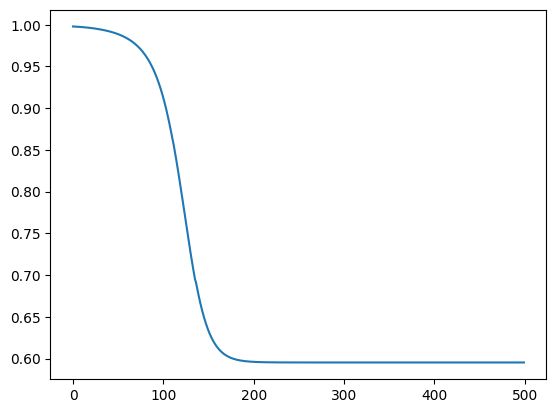

In [251]:
plt.plot(losses)

In [252]:
(losses[-1], unitary_scores[-1])

(0.5952404183078261, 0.0028562175835431525)

Extract cohomology phases

In [253]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sr_w2[3],
    data_b09_sl_w2[4],
    data_b09_sr_w2[4]
)

((-0.9999999999999999+2.0582131469894042e-17j), (-1-5.492673871663631e-17j))

In [254]:
extract_left_right_cohomology_phases(
    data_b09_sl_w2[3],
    data_b09_sb_w2[3],
    data_b09_sl_w2[4],
    data_b09_sb_w2[4]
)

((-1+5.529024971691232e-17j), (-1+7.709870254863923e-17j))

In [255]:
extract_left_right_cohomology_phases(
    data_b09_sr_w2[3],
    data_b09_sb_w2[3],
    data_b09_sr_w2[4],
    data_b09_sb_w2[4]
)

((-1-6.894062047576516e-17j), (-1+8.658833285659784e-17j))

### B=1.1

In [448]:
psi_11 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 1.1
)   

In [452]:
data_b11_sl_w2 = grad_descent_setup(psi_11, 2, [np_X, np_I]*30)

In [453]:
for _ in range(500):
    grad_descent_step(*data_b11_sl_w2, eta=0.1)

In [454]:
(*_, losses, unitary_scores) = data_b11_sl_w2

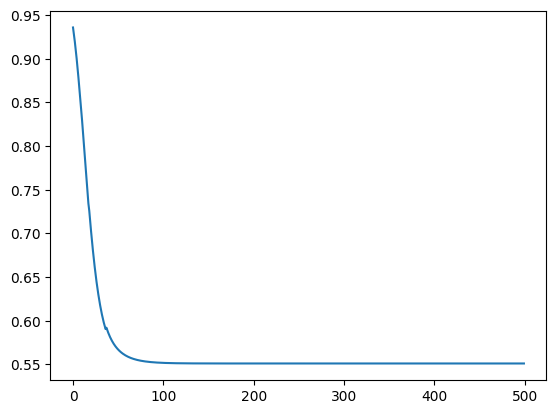

In [455]:
plt.plot(losses)

In [456]:
(losses[-1], unitary_scores[-1])

(0.5508770573736291, 0.0022556658046062328)

In [457]:
data_b11_sr_w2 = grad_descent_setup(psi_11, 2, [np_I, np_X]*30)

In [458]:
for _ in range(500):
    grad_descent_step(*data_b11_sr_w2, eta=0.1)

In [459]:
(*_, losses, unitary_scores) = data_b11_sr_w2

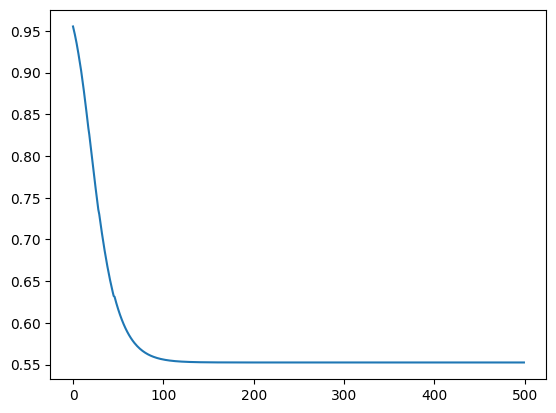

In [460]:
plt.plot(losses)

In [461]:
(losses[-1], unitary_scores[-1])

(0.5524292204259074, 0.004142732677526073)

In [462]:
data_b11_sb_w2 = grad_descent_setup(psi_11, 2, [np_X, np_X]*30)

In [463]:
for _ in range(500):
    grad_descent_step(*data_b11_sb_w2, eta=0.1)

In [464]:
(*_, losses, unitary_scores) = data_b11_sb_w2

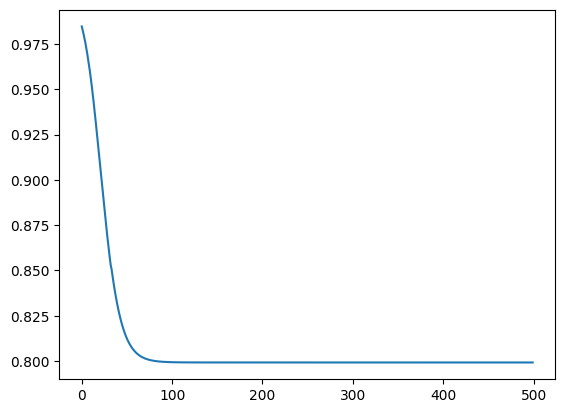

In [465]:
plt.plot(losses)

In [466]:
(losses[-1], unitary_scores[-1])

(0.7991723656158981, 0.0030952929775180937)

Extract cohomology phases

In [467]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sr_w2[3],
    data_b11_sl_w2[4],
    data_b11_sr_w2[4]
)

((1-5.5379015923639576e-17j), (1-4.1547646739246686e-17j))

In [468]:
extract_left_right_cohomology_phases(
    data_b11_sl_w2[3],
    data_b11_sb_w2[3],
    data_b11_sl_w2[4],
    data_b11_sb_w2[4]
)

((1-4.1581942719849055e-17j), (1+2.76590727016589e-17j))

In [469]:
extract_left_right_cohomology_phases(
    data_b11_sr_w2[3],
    data_b11_sb_w2[3],
    data_b11_sr_w2[4],
    data_b11_sb_w2[4]
)

((1-2.7747125816421663e-17j), (1-2.42494969546378e-17j))

## B=2

In [147]:
psi_b2 = next(
    d['wavefunction']
    for d in loaded_data
    if d['paramters']['B'] == 2
)   

In [194]:
data_b2_sl = grad_descent_setup(psi_b2, 8, [np_X, np_I]*20)

In [203]:
for _ in range(500):
    grad_descent_step(*data_b2_sl, eta=0.1)

In [204]:
(*_, losses, unitary_scores) = data_b2_sl

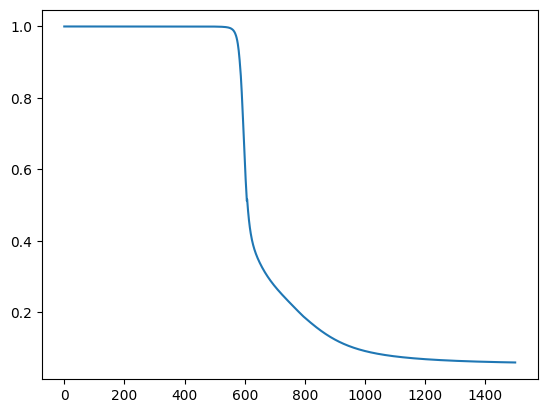

In [205]:
plt.plot(losses)

In [206]:
losses[-1]

0.05960599795016419

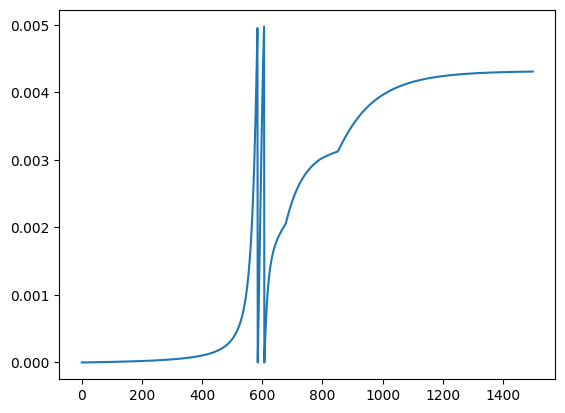

In [207]:
plt.plot(unitary_scores)

In [277]:
data_b2_sr = grad_descent_setup(psi_b2, 8, [np_I, np_X]*20)

In [286]:
for _ in range(100):
    grad_descent_step(*data_b2_sr, eta=0.01)

In [287]:
(*_, losses, unitary_scores) = data_b2_sr

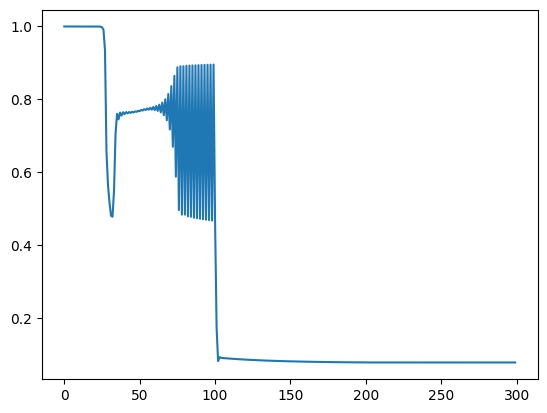

In [288]:
plt.plot(losses)

In [289]:
losses[-1]

0.07835060842494979

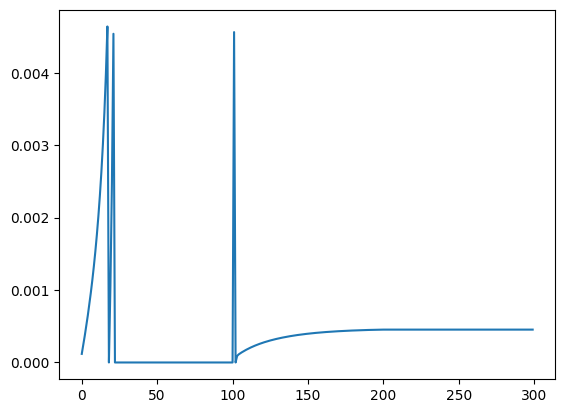

In [290]:
plt.plot(unitary_scores)

In [292]:
data_b2_sb = grad_descent_setup(psi_b2, 8, [np_X, np_X]*20)

In [296]:
for _ in range(100):
    grad_descent_step(*data_b2_sb, eta=0.03)

In [297]:
(*_, losses, unitary_scores) = data_b2_sb

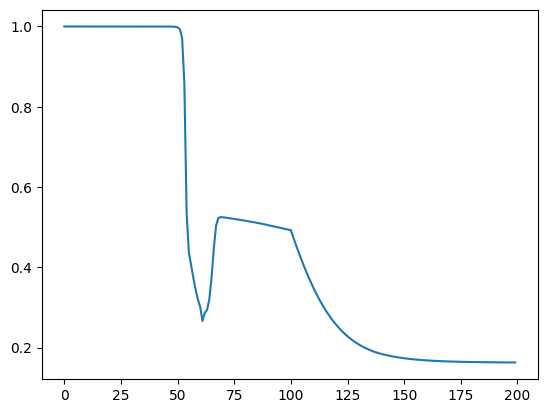

In [298]:
plt.plot(losses)

In [299]:
losses[-1]

0.16302224522649478

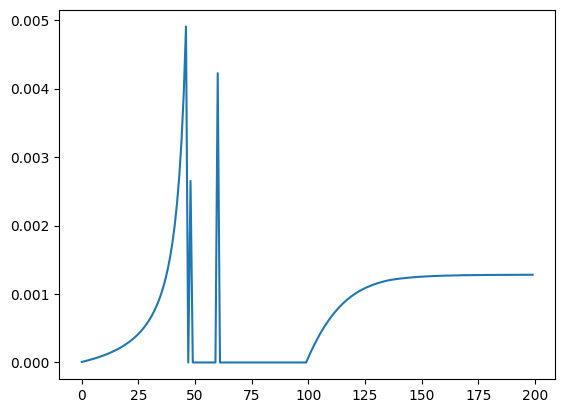

In [300]:
plt.plot(unitary_scores)

In [301]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sr[3],
    data_b2_sl[4],
    data_b2_sr[4]
)

((1+3.592437520339363e-18j), (1-5.861598361481182e-17j))

In [302]:
extract_left_right_cohomology_phases(
    data_b2_sl[3],
    data_b2_sb[3],
    data_b2_sl[4],
    data_b2_sb[4]
)

((1-4.0749306578459838e-19j), (1+6.586329295020432e-17j))

In [303]:
extract_left_right_cohomology_phases(
    data_b2_sr[3],
    data_b2_sb[3],
    data_b2_sr[4],
    data_b2_sb[4]
)

((1+1.4093646537662805e-16j), (1+5.022565751916143e-17j))

# Old code

In [116]:
def matrix_element_gradient(psi, symmetry_operations, left_unitaries,
                            right_unitaries, unitary_index, starting_psi_index):
    left_npc_unitaries = [to_npc_array(u) for u in left_unitaries]
    right_npc_unitaries = [to_npc_array(u) for u in right_unitaries]

    assert (unitary_index >= 0) and (unitary_index < len(left_unitaries) + len(right_unitaries))
    if unitary_index < len(left_unitaries):
        left_ops = left_npc_unitaries[:unitary_index]
        right_ops = left_npc_unitaries[unitary_index+1:] + symmetry_operations + right_npc_unitaries
    else:
        shifted_index = unitary_index - len(left_unitaries)
        left_ops = left_npc_unitaries + symmetry_operations + right_npc_unitaries[:shifted_index]
        right_ops = right_npc_unitaries[shifted_index+1:]

    starting_index = get_starting_index(psi, symmetry_operations, left_unitaries, right_unitaries)

    out = np.zeros((2,2),dtype='complex')
    
    for i in range(2):
        for j in range(2):
            delta_U = np.zeros((2,2),dtype='complex')
            delta_U[i,j] = 1
            ops_list = left_ops + [to_npc_array(delta_U),] + right_ops
            out[i,j] = psi.expectation_value_multi_sites(ops_list, starting_psi_index)
    
    return out

In [77]:
def all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries):
    left_outs = list()

    for unitary_index in range(len(left_unitaries)):
        left_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index))

    right_outs = list()

    for unitary_index in range(len(right_unitaries)):
        right_outs.append(matrix_element_gradient(psi, symmetry_operations, left_unitaries, right_unitaries, unitary_index+len(left_unitaries)))

    return (left_outs, right_outs)

In [149]:
def update(psi, symmetry_operations, left_unitaries, right_unitaries, losses, unitary_test_scores, eta=0.03, unitary_tol = 0.005):
    M = matrix_element(psi, symmetry_operations, left_unitaries, right_unitaries)

    left_gradients, right_gradients = all_matrix_element_gradients(psi, symmetry_operations, left_unitaries, right_unitaries)

    for u,d in zip(left_unitaries, left_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    for u,d in zip(right_unitaries, right_gradients):
        grad = -2*M*np.conj(d)
        u += -eta*projector(u, grad)

    losses.append(loss(psi, symmetry_operations, left_unitaries, right_unitaries))

    all_unitaries = left_unitaries + right_unitaries

    any_unitary_fail = any(
        unitary_test(u) > unitary_tol
        for u in all_unitaries
    )

    if any_unitary_fail:
        for i in range(len(left_unitaries)):
            u = left_unitaries[i]
            left_unitaries[i] = unitarize_matrix(u)
        for i in range(len(right_unitaries)):
            u = right_unitaries[i]
            right_unitaries[i] = unitarize_matrix(u)

    current_unitary_test_scores = [unitary_test(u) for u in all_unitaries]
    unitary_test_scores.append(current_unitary_test_scores)
    
    pass

In [100]:
def sample_unitaries(n):
    unitary_sampler = unitary_group(2)

    samples = [unitary_sampler.rvs() for _ in range(n)]

    return samples

In [150]:
single_losses = list()
single_unitary_scores = list()

left_unitaries = sample_unitaries(1)
right_unitaries = sample_unitaries(1)

In [167]:
single_symmetry_operations = transverse_cluster_symmetry_operation("single", 10)

In [151]:
for i in range(100):
    update(psi, symmetry_operations, left_unitaries, right_unitaries, single_losses, single_unitary_scores, eta=0.03)

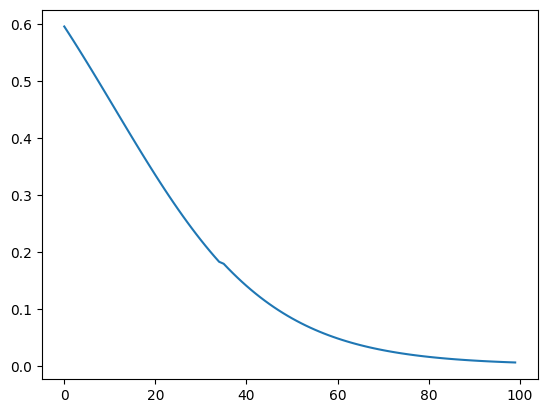

In [152]:
plt.plot(single_losses)

In [153]:
single_losses[-1]

0.006846379175071915

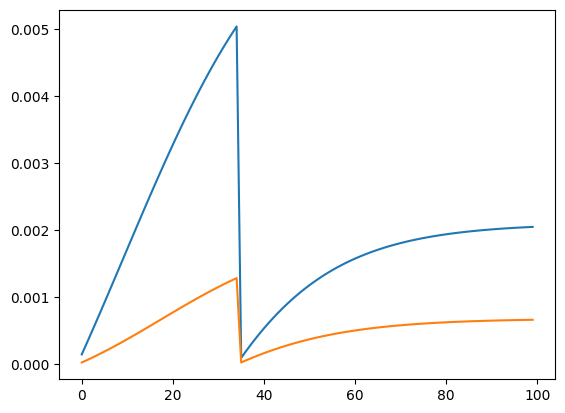

In [154]:
plt.plot(list(zip(*single_unitary_scores))[0])
plt.plot(list(zip(*single_unitary_scores))[1])

extract phase

In [170]:
single_phase = np.conj(matrix_element(psi, single_symmetry_operations, left_unitaries, right_unitaries))

In [37]:
unitary_tol = 0.005

In [38]:
def unitary_test(U):
    return np.max(np.abs(U.conj().T.dot(U)-np.identity(len(U))))

In [39]:
def unitarize_matrix(U):
    L,S,R = np.linalg.svd(U)
    return L.dot(R)

In [156]:
double_losses = list()
double_unitary_scores = list()

double_left_unitaries = sample_unitaries(2)
double_right_unitaries = sample_unitaries(2)

double_symmetry_operations = transverse_cluster_symmetry_operation("both", 10)

In [165]:
for i in range(100):
    update(
        psi,
        double_symmetry_operations,
        double_left_unitaries,
        double_right_unitaries,
        double_losses,
        double_unitary_scores,
        eta=0.03
    )

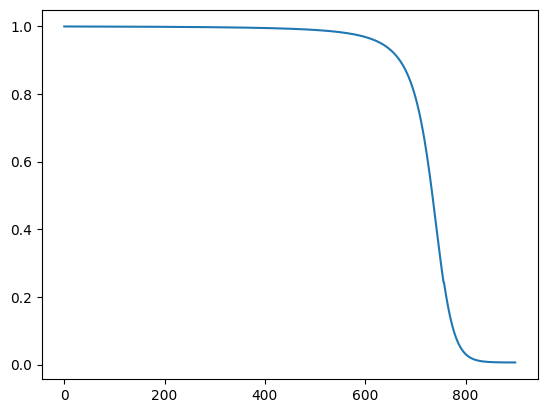

In [166]:
plt.plot(double_losses)

In [171]:
double_phase = np.conj(matrix_element(psi, double_symmetry_operations, double_left_unitaries, double_right_unitaries))

In [172]:
double_phase

(0.6171256903536819+0.7827851758858232j)

# Extract cohomology class

In [178]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[0]

In [179]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[-0.98575714-0.06602374j, -0.00320238-0.01708454j],
       [ 0.00320238-0.01708454j, -0.98575714+0.06602374j]])

Close enough to -1... where are the errors coming in?

In [180]:
U1 = single_phase*right_unitaries[0]
U2 = double_phase*double_right_unitaries[1]

In [181]:
U1.dot(U2).dot(np.conj(U1.T)).dot(np.conj(U2.T))

array([[ 0.9876098 -1.14769004e-05j, -0.00226331+1.58932079e-02j],
       [ 0.00226331+1.58932079e-02j,  0.9876098 +1.14769004e-05j]])

But not it's closer to +1...! Although perhaps this comparison doesn't make sense...
I need to work through this analytically.

# Sample losses

In [50]:
random_losses = list()

for i in range(100):
    U1 = unitary_sampler.rvs()
    U2 = unitary_sampler.rvs()
    U3 = unitary_sampler.rvs()
    U4 = unitary_sampler.rvs()

    ops_list = list()

    ops_list.append(to_npc_array(U1))
    ops_list.append(to_npc_array(U2))

    ops_list.extend([npc_X, npc_X]*num_symmetry_site_pairs)
    ops_list.append(to_npc_array(U3))
    ops_list.append(to_npc_array(U4))

    M = psi.expectation_value_multi_sites(ops_list, starting_index-1)

    M_loss = 1-(np.abs(M)**2)
    
    random_losses.append(M_loss)

In [51]:
min(random_losses)

0.9455882983600918